# Анализ и предобработка данных

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import librosa
import random

## Визуализация интонации с помощью спектрограмм

In [15]:
y_hap, sr_hap = librosa.load('example_wavs/happiness.wav', sr=16000)
y_sad, sr_sad = librosa.load('example_wavs/sadness.wav', sr=16000)

y_hap = y_hap / np.max(np.abs(y_hap))
y_sad = y_sad / np.max(np.abs(y_sad))

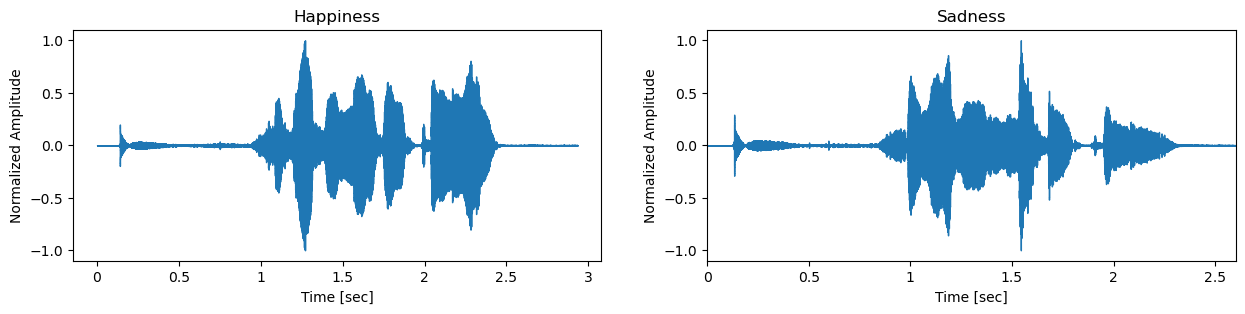

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))

librosa.display.waveshow(y_hap, sr=sr_hap, ax=ax[0])
ax[0].set(title='Happiness', ylabel='Normalized Amplitude', xlabel='Time [sec]')#, xlim=[0, 2.6])

librosa.display.waveshow(y_sad, sr=sr_sad, ax=ax[1])
ax[1].set(title='Sadness', ylabel='Normalized Amplitude', xlabel='Time [sec]', xlim=[0, 2.6])

plt.show()

### Частота основного тона

**Частота основного тона** (ЧОТ), Fundamental Frequency или F0 – это частота колебания голосовых связок при произнесении тоновых звуков. При произнесении нетоновых звуков , например говорении шепотом или произнесении шипящих и свистящих звуков, связки не колеблются, а значит эта характеристика для них не релевантна. 

Изменение частоты основного тона называют **интонацией**. При произнесении речи она непрерывно меняется в соответствии с ударением, подчеркиванием звуков и слов, а также при проявлении эмоций. 

In [17]:
f0_hap, voicing, voicing_p = librosa.pyin(y=y_hap, sr=sr_hap, fmin=64., fmax=1046., frame_length=512)
f0_sad, voicing, voicing_p = librosa.pyin(y=y_sad, sr=sr_sad, fmin=64., fmax=1046., frame_length=512)

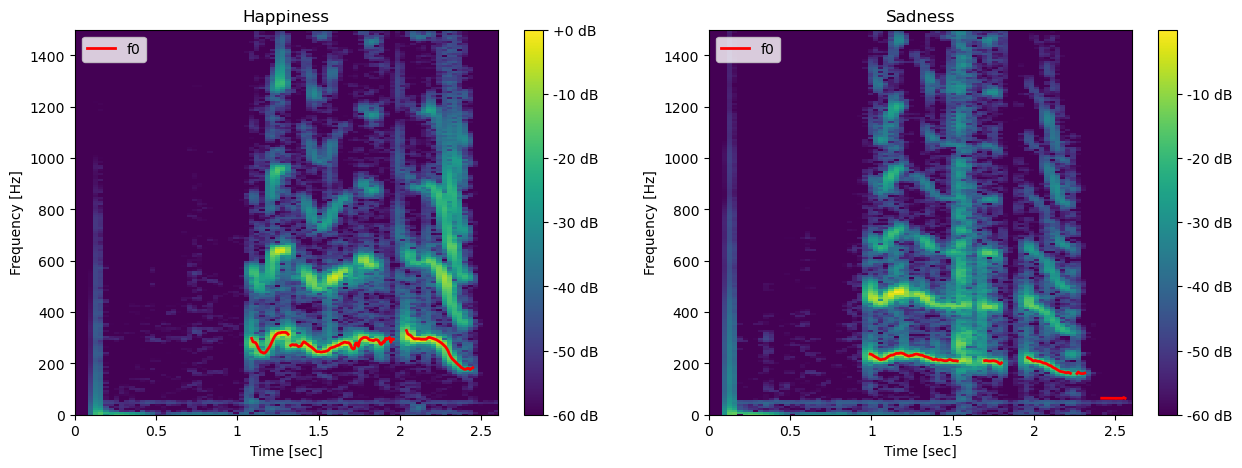

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

D = librosa.amplitude_to_db(np.abs(librosa.stft(y_hap)), ref=np.max)
img_hap = librosa.display.specshow(D, y_axis='linear', x_axis='time', sr=sr_hap, ax=ax[0], vmin=-60, cmap='viridis')
ax[0].set(title='Happiness', ylim=[0, 1500], ylabel='Frequency [Hz]', xlabel='Time [sec]', xlim=[0, 2.6])
ax[0].plot(librosa.times_like(f0_hap, sr=sr_hap * 4), f0_hap, label="f0", color='red', linewidth=2)
ax[0].legend(loc='upper left')
fig.colorbar(img_hap, ax=ax[0], format="%+2.f dB")

D = librosa.amplitude_to_db(np.abs(librosa.stft(y_sad)), ref=np.max)
img_sad = librosa.display.specshow(D, y_axis='linear', x_axis='time', sr=sr_sad, ax=ax[1], vmin=-60, cmap='viridis')
ax[1].set(title='Sadness', ylim=[0, 1500], ylabel='Frequency [Hz]', xlabel='Time [sec]', xlim=[0, 2.6])
ax[1].plot(librosa.times_like(f0_sad, sr=sr_hap * 4), f0_sad, label="f0", color='red', linewidth=2)
ax[1].legend(loc='upper left')
fig.colorbar(img_sad, ax=ax[1], format="%+2.f dB")

plt.show()

In [6]:
def normalize_harm(f0_harm):
        pos_mask = f0_harm > 0
        if len(f0_harm[pos_mask]) > 0:
            f0_harm[pos_mask] = np.log10(f0_harm[pos_mask])
            f0_harm[pos_mask] -= np.min(f0_harm[pos_mask])
            f0_harm = f0_harm / np.max(f0_harm)
        else:
            f0_harm = -np.ones(f0_harm.shape)
        return f0_harm
    
f0_harm_hap = librosa.f0_harmonics(np.abs(librosa.stft(y_hap, n_fft=512)), 
                                   freqs=librosa.fft_frequencies(sr=sr_hap, n_fft=512), 
                                   f0=f0_hap, harmonics=np.arange(1, 4))
norm_harm_hap = normalize_harm(f0_harm_hap)

f0_harm_sad = librosa.f0_harmonics(np.abs(librosa.stft(y_sad, n_fft=512)), 
                                   freqs=librosa.fft_frequencies(sr=sr_sad, n_fft=512), 
                                   f0=f0_sad, harmonics=np.arange(1, 4))
norm_harm_sad = normalize_harm(f0_harm_sad)

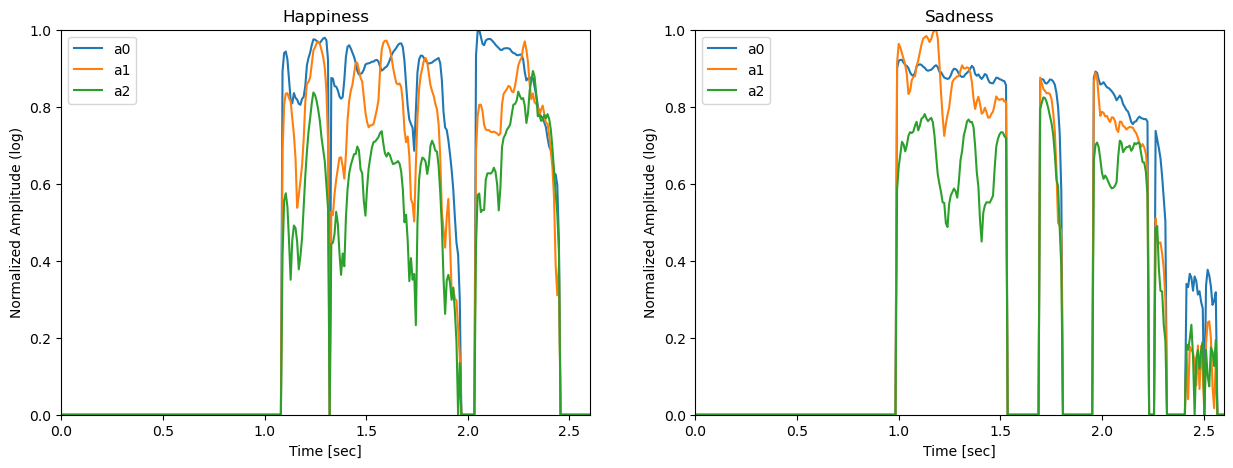

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

ax[0].set(title='Happiness', ylim=[0, 1], ylabel='Normalized Amplitude (log)', xlabel='Time [sec]', xlim=[0, 2.6])
for i in range(len(norm_harm_hap)):
    ax[0].plot(librosa.times_like(norm_harm_hap[i], sr=sr_hap * 4), norm_harm_hap[i], label='a{}'.format(i))
ax[0].legend(loc='upper left')

ax[1].set(title='Sadness', ylim=[0, 1], ylabel='Normalized Amplitude (log)', xlabel='Time [sec]', xlim=[0, 2.6])
for i in range(len(norm_harm_sad)):
    ax[1].plot(librosa.times_like(norm_harm_sad[i], sr=sr_sad * 4), norm_harm_sad[i], label='a{}'.format(i))
ax[1].legend(loc='upper left')

plt.show()

## Агрегация набора данных Dusha

Для обучения и тестирования моделей нейросетевого распознавания эмоций в аудиозаписях был выбран открытый набор данных [Dusha](https://habr.com/ru/companies/sberdevices/articles/715468/). 

В нем данные разделены на две категории:
- Crowd - собраны с помощью краудсорсинга;
- Podcast - короткие нарезки русскоязычных подкастов.

В каждой из категорий данные разделены на тренировочную и тестовую выборки так, чтобы одинаковые дикторы или подкасты не попали в обе выборки. Такое разделение позволяет валидировать и оценивать модели на новых данных, что уменьшает шанс влияния уникальных характеристик голоса человека на классификацию эмоции.

Таким образом, были выбраны:
- crowd_train для тренировочного набора данных,
- crowd_test для валидационного набора данных,
- podcast_train для тестового набора данных.

### Тренировочный набор данных 

#### Предварительный анализ

In [467]:
train_df = pd.read_csv('crowd/crowd_train/raw_crowd_train.tsv', sep='\t')
train_df.head()

hash_id   
0  475e76f77ac1ed7cabafca740b15b32a  \
1  2f9438ef68395c70a8714dc373a49d11   
2  9937036a9c0dba20eecbffddd00f2be2   
3  fb0ae78586a235018103acec22a80a8f   
4  196dcf9e1aaac46c2aee45e7f6adfb92   

                                  audio_path  duration annotator_emo   
0  wavs/475e76f77ac1ed7cabafca740b15b32a.wav  2.453000         angry  \
1  wavs/2f9438ef68395c70a8714dc373a49d11.wav  4.640000       neutral   
2  wavs/9937036a9c0dba20eecbffddd00f2be2.wav  4.341750       neutral   
3  wavs/fb0ae78586a235018103acec22a80a8f.wav  3.900562       neutral   
4  wavs/196dcf9e1aaac46c2aee45e7f6adfb92.wav  4.780000       neutral   

   golden_emo                      annotator_id   
0         NaN  858305a5450b7bd1288ba0053b1cd1c1  \
1         NaN  858305a5450b7bd1288ba0053b1cd1c1   
2         2.0  858305a5450b7bd1288ba0053b1cd1c1   
3         NaN  858305a5450b7bd1288ba0053b1cd1c1   
4         NaN  858305a5450b7bd1288ba0053b1cd1c1   

                              speaker_text speaker_emo   
0          не надо не надо не надо не надо       angry  \
1                        фозил кори mp три     neutral   
2                                      NaN         NaN   
3                сколько стоит на керамбит     neutral   
4  афина когда закончится эта телепередача     neutral   

                          source_id  
0  fa136da095807ea6cd18dd6e2f58d4d0  
1  3d436884cbbe25373914f8768de494f7  
2                               NaN  
3  80bc833cf6b3f106d2e8991783a31e2b  
4  bd78f079676fa5f1ed17253c9a440cc6

Изучение данных показало, что в исходной неагрегированной таблице данных содержатся следующие поля:
- hash_id — уникальный идентификатор аудиофайла;
- audio_path — путь к аудиофайлу;
- duration — длительность аудиофайла;
- annotator_emo — эмоция, которую указал разметчик;
- golden_emo — эмоция контрольного задания;
- annotator_id — уникальный идентификатор разметчика, который оценивает эмоцию; 
- speaker_text — текст, который произнёс диктор;
- speaker_emo — эмоция, которую выражал диктор («заказанная» эмоция для разметчика-диктора из первой группы для семплов из Crowd, None для семплов из Podcasts);
- source_id — уникальный идентификатор диктора или подкаста.

In [468]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 906953 entries, 0 to 906952
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   hash_id        906953 non-null  object 
 1   audio_path     906953 non-null  object 
 2   duration       906953 non-null  float64
 3   annotator_emo  906953 non-null  object 
 4   golden_emo     141613 non-null  float64
 5   annotator_id   906953 non-null  object 
 6   speaker_text   829176 non-null  object 
 7   speaker_emo    829176 non-null  object 
 8   source_id      829176 non-null  object 
dtypes: float64(2), object(7)
memory usage: 62.3+ MB


Всего в таблице 906953 строки. 

Из них 141613 являются контрольными заданиями.

In [469]:
train_df[train_df['source_id'].isna() & train_df['speaker_text'].isna() & train_df['speaker_emo'].isna()].info()

<class 'pandas.core.frame.DataFrame'>
Index: 77777 entries, 2 to 906952
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   hash_id        77777 non-null  object 
 1   audio_path     77777 non-null  object 
 2   duration       77777 non-null  float64
 3   annotator_emo  77777 non-null  object 
 4   golden_emo     77777 non-null  float64
 5   annotator_id   77777 non-null  object 
 6   speaker_text   0 non-null      object 
 7   speaker_emo    0 non-null      object 
 8   source_id      0 non-null      object 
dtypes: float64(2), object(7)
memory usage: 5.9+ MB


77777 строк имеют пропуски в данных в столбцах speaker_text, speaker_emo, source_id.

In [470]:
train_df['hash_id'].value_counts()

hash_id
11675ab24a0d0ce8e0daa859c941d764    134
606ec9b269932bfa321c203644c4b9bf    120
b67256df70b2d1f8d03f54a0629bf390    120
6f7893a6cda98688442e8080d869bf0f    118
3761cc07bb80b18356b524c2dab49076    117
                                   ... 
c58063a19209d0591b38a7d546a5a0e1      1
2f84d605e7352fb52d742c24d8b579d1      1
7464113a5abe4aaf56037d35e46029ad      1
38fd0611cac0e2332dd864a7af57adf1      1
4a3d3602171be4ef49eb43b1436acfc5      1
Name: count, Length: 184633, dtype: int64

Каждая уникальная аудиозапись оценивалась 1-134 разными разметчиками.

In [471]:
train_df['annotator_emo'].value_counts()

annotator_emo
neutral     559501
sad         164671
positive     87258
angry        85527
other         9996
Name: count, dtype: int64

#### Шум в данных

In [472]:
train_df.groupby(['hash_id', 'speaker_emo'], as_index=False).size()

hash_id speaker_emo  size
0       00000d522439136554c888f4cfd92131     neutral     5
1       000039c2bc753aa5a776621a4707eb73     neutral     5
2       000043e573826e21659ef9401d4ba84f     neutral     5
3       000062a9bd8daf199cc520508902b304       angry     2
4       000182128001302626efa6032d095cc8     neutral     2
...                                  ...         ...   ...
183081  fffdcb6c9078c84c88d65752474c8945     neutral     2
183082  fffe6e2189d87d2bcf4e10fba9a4aa73       angry     3
183083  fffeba24094a8cdf1737387158a8b220     neutral     2
183084  fffeefeeb5cc057d212d08dab33b9b56         sad     7
183085  ffff4f25708e1f04fe8825f2184fcb59         sad     1

[183086 rows x 3 columns]

В данных можно встретить аудиозаписи с одинаковым значением hash_id, но разными текстами и эмоциями диктора. При проверке нескольких примеров, оказалось, что данные аудиозаписи не содержат никаких голосов.

In [473]:
value_counts = train_df.groupby(['hash_id', 'speaker_emo'], as_index=False).size()['hash_id'].value_counts()
value_counts[value_counts > 1]

hash_id
eed55d116dc863ebeba377e367a556d1    3
0ecca85f291b7c844da08f35624473e1    3
c75a065f0e8ff0a94dfccf6d9bf84879    3
28043bcf9c5ecae2f789c91d51ef6109    3
d79d42c3610c1b08cc834d661d262482    3
b62b60cfd530d0a825a5af4c54a4d64d    2
927ea81b96b6ae954e3662cd286e98a1    2
722fdc44c5157f38cb032997f1c0d711    2
9c824fb8c3cd54c1a0ac1ade10ea4d93    2
46ccf7325e140b160d83f89a6862cdb9    2
699fb0be48fb0e223e72b595695dd844    2
11b982151840762df2a401ca71363930    2
534f5aaae4263780cd0efd64b8198ed7    2
0c88918aa3e242fe78327044fcac7255    2
caee18a1282f7ab200a7f74a40c717f6    2
b6c1099e9b41d05d884ffac355023aac    2
3134a2c7e53ee4509bd18f1c39efb534    2
121eb3609b3cc5cead85a00e906a7e1a    2
e4f42fd23fa8ba6a6319a7819f1d7c4e    2
146e54639951997a0ab41e0a8a24733f    2
ef9e82aeb6ce2f5a84ee6addacd07be0    2
3d6dfc4d665ed2427398ecf7094fff52    2
e01b8760fc37fe8b8c4cc03c90e9a0e0    2
0724bd480ff53657d245ce4f92e34f33    2
17a9436e3782eaf0fa4b29a3367b5995    2
97be4dcc334212386ddf7efeb6c95a7f    2
Name

In [474]:
train_df[train_df['hash_id'] =='0ecca85f291b7c844da08f35624473e1'][['hash_id', 'annotator_emo',
                                                                    'speaker_text', 'speaker_emo', 'source_id']]

hash_id annotator_emo   
112401  0ecca85f291b7c844da08f35624473e1         other  \
112407  0ecca85f291b7c844da08f35624473e1         other   
112492  0ecca85f291b7c844da08f35624473e1         other   
124320  0ecca85f291b7c844da08f35624473e1         other   
124579  0ecca85f291b7c844da08f35624473e1         other   
124684  0ecca85f291b7c844da08f35624473e1         other   
163717  0ecca85f291b7c844da08f35624473e1         other   
163723  0ecca85f291b7c844da08f35624473e1         other   

                          speaker_text speaker_emo   
112401    сколько раз ты еще повторишь       angry  \
112407    сколько раз ты еще повторишь       angry   
112492    сколько раз ты еще повторишь       angry   
124320                     я недоволен         sad   
124579                     я недоволен         sad   
124684                     я недоволен         sad   
163717  как зарина резервировать кошку     neutral   
163723  как зарина резервировать кошку     neutral   

                               source_id  
112401  c2254df3e27d4a21beeac9b99a99e36e  
112407  c2254df3e27d4a21beeac9b99a99e36e  
112492  c2254df3e27d4a21beeac9b99a99e36e  
124320  c2254df3e27d4a21beeac9b99a99e36e  
124579  c2254df3e27d4a21beeac9b99a99e36e  
124684  c2254df3e27d4a21beeac9b99a99e36e  
163717  c2254df3e27d4a21beeac9b99a99e36e  
163723  c2254df3e27d4a21beeac9b99a99e36e

In [475]:
train_df[train_df['hash_id'].isin(value_counts[value_counts > 1].index)][['hash_id', 'annotator_emo',
                                                                          'speaker_text', 'speaker_emo', 'source_id']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 224 entries, 6339 to 337479
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   hash_id        224 non-null    object
 1   annotator_emo  224 non-null    object
 2   speaker_text   224 non-null    object
 3   speaker_emo    224 non-null    object
 4   source_id      224 non-null    object
dtypes: object(5)
memory usage: 10.5+ KB


Такие записи не содержат пропусков в столбцах speaker_text, speaker_emo, source_id.

In [476]:
df = train_df[train_df['hash_id'].isin(value_counts[value_counts > 1].index)].groupby(['hash_id', 'annotator_emo'], as_index=False).size().sort_values(by=['hash_id'])
emo = df['annotator_emo'].unique()
new_df = pd.DataFrame(columns=['hash_id', *emo])
for hash_id in df['hash_id'].unique():
    new_df.loc[len(new_df.index)] = [hash_id, *[0 for _ in range(len(emo))]]
    for idx, row in df[df['hash_id'] == hash_id].iterrows():
        new_df.loc[new_df.index[-1], row['annotator_emo']] += row['size']
new_df

hash_id  other  neutral  sad
0   0724bd480ff53657d245ce4f92e34f33     13        0    0
1   0c88918aa3e242fe78327044fcac7255     12        0    0
2   0ecca85f291b7c844da08f35624473e1      8        0    0
3   11b982151840762df2a401ca71363930      4        1    0
4   121eb3609b3cc5cead85a00e906a7e1a      4        0    0
5   146e54639951997a0ab41e0a8a24733f      7        0    0
6   17a9436e3782eaf0fa4b29a3367b5995      4        0    0
7   28043bcf9c5ecae2f789c91d51ef6109      8        0    0
8   3134a2c7e53ee4509bd18f1c39efb534     17        0    0
9   3d6dfc4d665ed2427398ecf7094fff52      5        0    0
10  46ccf7325e140b160d83f89a6862cdb9      5        0    0
11  534f5aaae4263780cd0efd64b8198ed7      7        1    0
12  699fb0be48fb0e223e72b595695dd844      7        0    0
13  722fdc44c5157f38cb032997f1c0d711      5        0    0
14  927ea81b96b6ae954e3662cd286e98a1      6        0    0
15  97be4dcc334212386ddf7efeb6c95a7f      7        1    1
16  9c824fb8c3cd54c1a0ac1ade10ea4d93      8        1    0
17  b62b60cfd530d0a825a5af4c54a4d64d      6        1    0
18  b6c1099e9b41d05d884ffac355023aac      4        0    0
19  c75a065f0e8ff0a94dfccf6d9bf84879     23        0    0
20  caee18a1282f7ab200a7f74a40c717f6     17        0    0
21  d79d42c3610c1b08cc834d661d262482     13        0    0
22  e01b8760fc37fe8b8c4cc03c90e9a0e0      5        0    0
23  e4f42fd23fa8ba6a6319a7819f1d7c4e      4        1    0
24  eed55d116dc863ebeba377e367a556d1     12        0    0
25  ef9e82aeb6ce2f5a84ee6addacd07be0      5        1    0

Такие записи оцениваются большинством разметчиков меткой other (запись слишком тихая, шипение, стук, никаких голосов), поэтому при дальнейшей обработке будут отброшены.

#### Фильтрация по количеству оценщиков и пропускам в данных

Будем рассматривать аудиозаписи, которые оценивали не менее 5 разметчиков, с длительностью не более 10 секунд.

В дальнейшей работе нам не понадобятся столбцы:
- golden_emo (не важно, является ли аудиофайл контрольным заданием), 
- speaker_text (для анализа эмоции по интонации не нужен текст), 
- speaker_emo (выделение эмоции аудиозаписи будем делать на основе большинства голосов разметчиков), 
- duration, 
- annotator_id. 

Также с оставшихся данных удалим строки с неизвестным источником аудиозаписи (пропущено значение source_id)

In [478]:
threshold = 5 # пороговое количество оценщиков эмоции аудиозаписи
value_counts = train_df['hash_id'].value_counts()
to_remove = value_counts[value_counts < threshold].index
new_train_df = train_df.drop(train_df[train_df['hash_id'].isin(to_remove)].index)
new_train_df.drop(new_train_df[new_train_df['duration'] > 10].index, inplace=True) # фильтрация по длительности
new_train_df.drop(columns=['golden_emo', 'speaker_text', 'speaker_emo', 'duration', 'annotator_id'], inplace=True)
new_train_df.dropna(inplace=True)
value_counts = new_train_df['hash_id'].value_counts()
cnts = [value_counts[hash_id] for hash_id in new_train_df['hash_id']]
new_train_df['cnt_annotators'] = cnts
value_counts

hash_id
96bd32939ce9e2b8e12b83dfa0546ad6    64
3c33ed722547591f718a29ca48e673ec    58
8a773f353c808feb18420a3a1f1832a7    58
f5aafbdf92004058d1d3d41ea464e63b    58
7d624fb5f08095ee7f78c8fa90a453f7    56
                                    ..
bd11c3a0ade9f79f0c2979ada4fc9636     5
98553722701b3221c107e92d1d71f0ad     5
81366212606a8a2dbae1e3689cb179d1     5
b4eb552920d91e81d05328d11720ca68     5
49facb0c4ea4100931a1ee80310d2708     5
Name: count, Length: 64787, dtype: int64

In [479]:
new_train_df.head()

hash_id   
2990  2d003d1c8ed5e8a28502f2d0aaafa814  \
3002  2d003d1c8ed5e8a28502f2d0aaafa814   
3003  cb693a15572d54dc81575109e220211c   
3004  5cc28c307aab8f18bf6504ec1bfe241d   
3005  1b905acf85c0f8d9a527edf3c83f19a8   

                                     audio_path annotator_emo   
2990  wavs/2d003d1c8ed5e8a28502f2d0aaafa814.wav         other  \
3002  wavs/2d003d1c8ed5e8a28502f2d0aaafa814.wav         other   
3003  wavs/cb693a15572d54dc81575109e220211c.wav       neutral   
3004  wavs/5cc28c307aab8f18bf6504ec1bfe241d.wav       neutral   
3005  wavs/1b905acf85c0f8d9a527edf3c83f19a8.wav       neutral   

                             source_id  cnt_annotators  
2990  c2254df3e27d4a21beeac9b99a99e36e               6  
3002  c2254df3e27d4a21beeac9b99a99e36e               6  
3003  4420033571382c6cf179b16b200d7260               5  
3004  55c03c75f0d6d7a31f75c5b14966dc3d               5  
3005  abcd8ff9b229bc200d98d8abd80e2beb               5

In [480]:
new_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 511008 entries, 2990 to 906950
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   hash_id         511008 non-null  object
 1   audio_path      511008 non-null  object
 2   annotator_emo   511008 non-null  object
 3   source_id       511008 non-null  object
 4   cnt_annotators  511008 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 23.4+ MB


#### Агрегация аудиозаписей по эмоции, выбранной большинством

Сгруппируем записи по количеству записей для каждой эмоции, выделенной разметчиком в каждой аудиозаписи. 

Сохраним для каждой аудиозаписи эмоцию, которая выбрана большинством разметчиков и удалим записи с меткой other.

In [481]:
grouped_train_df = new_train_df.groupby(['hash_id', 'audio_path', 'annotator_emo', 
                                         'source_id', 'cnt_annotators'], as_index=False).size()
grouped_train_df['emotion'] = [(row['annotator_emo'], row['size']) for index, row in grouped_train_df.iterrows()]
grouped_train_df = grouped_train_df.groupby(['hash_id', 'audio_path', 'source_id', 'cnt_annotators'],
                                            as_index=False)[['emotion']].agg(lambda x: max(x, key = lambda i: i[1]))
grouped_train_df['emotion'] = [emo[0] for emo in grouped_train_df['emotion']]
grouped_train_df.drop(grouped_train_df[grouped_train_df['emotion'] == 'other'].index, inplace=True)
grouped_train_df.sort_values(by='cnt_annotators', ascending=False, inplace=True, ignore_index=True)
grouped_train_df.head(10)

hash_id   
0  96bd32939ce9e2b8e12b83dfa0546ad6  \
1  8a773f353c808feb18420a3a1f1832a7   
2  3c33ed722547591f718a29ca48e673ec   
3  f5aafbdf92004058d1d3d41ea464e63b   
4  99aa037d9df5748deef11af244920c0d   
5  7d624fb5f08095ee7f78c8fa90a453f7   
6  48c98eb7c8f3973faafebdf68f74bff0   
7  59469ac60ec525d8b102741d9384d8c3   
8  225e552d7dca9d23a3ff884a9d506af0   
9  31da2f890e6ad4dfc277ded128dfeac9   

                                  audio_path   
0  wavs/96bd32939ce9e2b8e12b83dfa0546ad6.wav  \
1  wavs/8a773f353c808feb18420a3a1f1832a7.wav   
2  wavs/3c33ed722547591f718a29ca48e673ec.wav   
3  wavs/f5aafbdf92004058d1d3d41ea464e63b.wav   
4  wavs/99aa037d9df5748deef11af244920c0d.wav   
5  wavs/7d624fb5f08095ee7f78c8fa90a453f7.wav   
6  wavs/48c98eb7c8f3973faafebdf68f74bff0.wav   
7  wavs/59469ac60ec525d8b102741d9384d8c3.wav   
8  wavs/225e552d7dca9d23a3ff884a9d506af0.wav   
9  wavs/31da2f890e6ad4dfc277ded128dfeac9.wav   

                          source_id  cnt_annotators  emotion  
0  12203e38b10471d739edb03396fa8d5f              64  neutral  
1  029cc3ae86d3180bc1f59f55431b2ac2              58  neutral  
2  28dca592eafd755414f4ba85299484e2              58  neutral  
3  e538bed86155e9fc2d22359947744436              58  neutral  
4  71d95d274188ea1e91b3a136e71e1053              56  neutral  
5  fa8aa15b5944f37eb815a5a9180c3538              56  neutral  
6  02d58cb47f02f8884aaa45b0f7dd7714              55  neutral  
7  934357540d5a4c53d22dfd7bd96939bb              55  neutral  
8  fa1d49c1c0401c3f65e09d32ccbfabd4              55  neutral  
9  acaf330d14ef606c8e0b25af8e243161              55      sad

In [482]:
train_emo_value_counts = grouped_train_df['emotion'].value_counts()
train_emo_value_counts

emotion
neutral     48979
sad         10568
positive     2362
angry        2335
Name: count, dtype: int64

Выборка получилась сильно несбалансированной: 
- количество аудиозаписей, размеченных нейтральной эмоцией, сильно преобладает,
- аудиозаписей, размеченных как грусть, также сильно больше, в сравнении с радостью и злостью.

#### Баланс классов

Чтобы сбалансировать классы, отбросим часть данных c наименьшим количеством разметчиков случайным образом до равного количества для каждой эмоции.

In [483]:
emotions = grouped_train_df['emotion'].unique()
balanced_train_df = grouped_train_df.copy()
for emotion in emotions:
    idxs = balanced_train_df[balanced_train_df['emotion'] == emotion].index
    balanced_train_df.drop(idxs[train_emo_value_counts[-1]:], inplace=True)
balanced_train_df.reset_index(drop=True, inplace=True)
balanced_train_df['emotion'].value_counts()

emotion
neutral     2335
sad         2335
positive    2335
angry       2335
Name: count, dtype: int64

In [484]:
balanced_train_df.head()

hash_id   
0  96bd32939ce9e2b8e12b83dfa0546ad6  \
1  8a773f353c808feb18420a3a1f1832a7   
2  3c33ed722547591f718a29ca48e673ec   
3  f5aafbdf92004058d1d3d41ea464e63b   
4  99aa037d9df5748deef11af244920c0d   

                                  audio_path   
0  wavs/96bd32939ce9e2b8e12b83dfa0546ad6.wav  \
1  wavs/8a773f353c808feb18420a3a1f1832a7.wav   
2  wavs/3c33ed722547591f718a29ca48e673ec.wav   
3  wavs/f5aafbdf92004058d1d3d41ea464e63b.wav   
4  wavs/99aa037d9df5748deef11af244920c0d.wav   

                          source_id  cnt_annotators  emotion  
0  12203e38b10471d739edb03396fa8d5f              64  neutral  
1  029cc3ae86d3180bc1f59f55431b2ac2              58  neutral  
2  28dca592eafd755414f4ba85299484e2              58  neutral  
3  e538bed86155e9fc2d22359947744436              58  neutral  
4  71d95d274188ea1e91b3a136e71e1053              56  neutral

### Валидационный набор данных 

Проведем анализ и предобработку валидационной выборки аналогично тренировочной.

#### Предварительный анализ

In [485]:
val_df = pd.read_csv('crowd/crowd_test/raw_crowd_test.tsv', sep='\t')
val_df.head()

hash_id   
0  9e9961c53ca6eeb440b217e539fbf46c  \
1  0166f65a30354db8282682b1a280e64c   
2  d49a6b560155831725a7bdc7d0a96099   
3  c6852b0925797612d7b6724da8cbe7b4   
4  0166f65a30354db8282682b1a280e64c   

                                  audio_path  duration annotator_emo   
0  wavs/9e9961c53ca6eeb440b217e539fbf46c.wav      5.82       neutral  \
1  wavs/0166f65a30354db8282682b1a280e64c.wav      3.70           sad   
2  wavs/d49a6b560155831725a7bdc7d0a96099.wav      4.38       neutral   
3  wavs/c6852b0925797612d7b6724da8cbe7b4.wav      8.58       neutral   
4  wavs/0166f65a30354db8282682b1a280e64c.wav      3.70           sad   

   golden_emo                      annotator_id   
0         NaN  858305a5450b7bd1288ba0053b1cd1c1  \
1         NaN  858305a5450b7bd1288ba0053b1cd1c1   
2         NaN  858305a5450b7bd1288ba0053b1cd1c1   
3         NaN  858305a5450b7bd1288ba0053b1cd1c1   
4         NaN  a5562e26cd8f1949488a2d1e1e549d97   

                        speaker_text speaker_emo   
0                           я слушаю     neutral  \
1                    каким стал сбер     neutral   
2           где родился шерлок холмс     neutral   
3  открой в браузере ennio morricone     neutral   
4                    каким стал сбер     neutral   

                          source_id  
0  4282ddc30d71ef420e202e0c60391e9f  
1  d70dc98ed56e9362eaefefb7b2827c8f  
2  0ee35d2abecf4272ecc8e1539b0839d8  
3  0855e363c1787df1592f58f7a27ebe13  
4  d70dc98ed56e9362eaefefb7b2827c8f

In [486]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79088 entries, 0 to 79087
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   hash_id        79088 non-null  object 
 1   audio_path     79088 non-null  object 
 2   duration       79088 non-null  float64
 3   annotator_emo  79088 non-null  object 
 4   golden_emo     6998 non-null   float64
 5   annotator_id   79088 non-null  object 
 6   speaker_text   77833 non-null  object 
 7   speaker_emo    77833 non-null  object 
 8   source_id      77833 non-null  object 
dtypes: float64(2), object(7)
memory usage: 5.4+ MB


In [487]:
val_df[val_df['source_id'].isna() & val_df['speaker_text'].isna() & val_df['speaker_emo'].isna()].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1255 entries, 77833 to 79087
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   hash_id        1255 non-null   object 
 1   audio_path     1255 non-null   object 
 2   duration       1255 non-null   float64
 3   annotator_emo  1255 non-null   object 
 4   golden_emo     1255 non-null   float64
 5   annotator_id   1255 non-null   object 
 6   speaker_text   0 non-null      object 
 7   speaker_emo    0 non-null      object 
 8   source_id      0 non-null      object 
dtypes: float64(2), object(7)
memory usage: 98.0+ KB


In [488]:
val_df['hash_id'].value_counts()

hash_id
a7249b5265c4519ab50d473a19a1338b    149
28966a4b648a399f03e07db6d9bb5b5f    138
1051145969a460dce5d726a19b5314ae    136
1bdfd3d71c90001023f490f46aa5bed1    133
99baaf6ed01355a799311d49121e0a0f    132
                                   ... 
f21f38454a4305ab503c4083445dba51      1
c38d12e4a2d5cf70dd4c55e990d9f437      1
313f6c1bb441b2d93725ee0edb2fcbf5      1
23bb21c726cd89a19b8dfcac2dcdb07d      1
54e1e4c8b8c3cf96cc3758ca522afa74      1
Name: count, Length: 17217, dtype: int64

In [489]:
val_df['annotator_emo'].value_counts()

annotator_emo
neutral     48917
sad         17603
angry        5987
positive     5775
other         806
Name: count, dtype: int64

#### Шум в данных

In [490]:
val_df.groupby(['hash_id', 'speaker_emo'], as_index=False).size()

hash_id speaker_emo  size
0      0004eb46b532c20b2f181f1a65d3ff17     neutral     5
1      0006985a7b739719a77be07ff64a4274     neutral     3
2      00075643862a22ee402edd404c4fee93       angry     2
3      00117e5b11d1490c25eea137983ca994         sad     1
4      00173c4925e5a20cd1495742505ec0d2         sad    17
...                                 ...         ...   ...
17212  ffd655d7d6bdb232e4026030d34b68ab         sad     5
17213  ffe114628f66425ba5d27fba46c0e29b         sad     1
17214  ffe6153103e242f1a3b3724a336c9902     neutral     8
17215  fff3b44fd6da710cd768221a5e23684d    positive     4
17216  fffec009ec501b16ca348dde8af8abca       angry     5

[17217 rows x 3 columns]

In [491]:
value_counts = val_df.groupby(['hash_id', 'speaker_emo'], as_index=False).size()['hash_id'].value_counts()
value_counts

hash_id
0004eb46b532c20b2f181f1a65d3ff17    1
aba405e371d1a8cb5b9b63b02cfe69d2    1
ab6d0cd1c24d0e599c8c64fcab8e4e33    1
ab6e4abbebad3d9a8e29a5fa69993498    1
ab7164c293e855e6369a8d7dae513d38    1
                                   ..
5660c4dbf8c1d59845aa928b5a313478    1
5663b44c660de42656874c195ed80d7f    1
56646724512fa7d58eeb7d5644addfb4    1
56649a5e47923bf8eb1108f7bcc6e704    1
fffec009ec501b16ca348dde8af8abca    1
Name: count, Length: 17217, dtype: int64

В отличие от тренировочной выборки, в валидационной не было обнаружено шума в данных.

#### Фильтрация по количеству оценщиков и пропускам в данных

In [492]:
threshold = 5 # пороговое количество оценщиков эмоции аудиозаписи
value_counts = val_df['hash_id'].value_counts()
to_remove = value_counts[value_counts < threshold].index
new_val_df = val_df.drop(val_df[val_df['hash_id'].isin(to_remove)].index)
new_val_df.drop(new_val_df[new_val_df['duration'] > 10].index, inplace=True) # фильтрация по длительности
new_val_df.drop(columns=['golden_emo', 'speaker_text', 'speaker_emo', 'duration', 'annotator_id'], inplace=True)
new_val_df.dropna(inplace=True)
value_counts = new_val_df['hash_id'].value_counts()
cnts = [value_counts[hash_id] for hash_id in new_val_df['hash_id']]
new_val_df['cnt_annotators'] = cnts
value_counts

hash_id
f105541bb4852c67766ea4fcb1af2503    56
8c6db4743dd8f40e4bf17171013a9162    54
7d662e81b1d664abebfc8a280b1e8339    53
063b43d02a5f21a8f88baa285c19fa04    51
d42ed25ef28677dc6f9334f2b93945f1    51
                                    ..
00e5db92853514e40862dd0a339ff2f6     5
bd81478bb9ffd879b4d5fb1a187dbae7     5
197502a08c4b0af5e637c9b806313658     5
7f7ac439514cf9afdabef0d6a964f3ec     5
33d5c85bb22b22e4fdc5072cff45fda6     5
Name: count, Length: 6077, dtype: int64

In [493]:
new_val_df.head()

hash_id   
257  04d93db85d4a951fc5f8b7f3ed7c075c  \
258  04d93db85d4a951fc5f8b7f3ed7c075c   
265  04d93db85d4a951fc5f8b7f3ed7c075c   
268  4794ac9f2f26f8ee7b3a81e660f4a377   
269  4794ac9f2f26f8ee7b3a81e660f4a377   

                                    audio_path annotator_emo   
257  wavs/04d93db85d4a951fc5f8b7f3ed7c075c.wav         other  \
258  wavs/04d93db85d4a951fc5f8b7f3ed7c075c.wav         other   
265  wavs/04d93db85d4a951fc5f8b7f3ed7c075c.wav         other   
268  wavs/4794ac9f2f26f8ee7b3a81e660f4a377.wav         angry   
269  wavs/4794ac9f2f26f8ee7b3a81e660f4a377.wav         angry   

                            source_id  cnt_annotators  
257  55bec9a29fc85a458053106a3bd291fa               5  
258  55bec9a29fc85a458053106a3bd291fa               5  
265  55bec9a29fc85a458053106a3bd291fa               5  
268  aa38ee6e523e1d206e0d4decfacbe661               5  
269  aa38ee6e523e1d206e0d4decfacbe661               5

In [494]:
new_val_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47804 entries, 257 to 77823
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   hash_id         47804 non-null  object
 1   audio_path      47804 non-null  object
 2   annotator_emo   47804 non-null  object
 3   source_id       47804 non-null  object
 4   cnt_annotators  47804 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.2+ MB


#### Агрегация аудиозаписей по эмоции, выбранной большинством

In [495]:
grouped_val_df = new_val_df.groupby(['hash_id', 'audio_path', 'annotator_emo', 
                                     'source_id', 'cnt_annotators'], as_index=False).size()
grouped_val_df['emotion'] = [(row['annotator_emo'], row['size']) for index, row in grouped_val_df.iterrows()]
grouped_val_df = grouped_val_df.groupby(['hash_id', 'audio_path', 'source_id', 'cnt_annotators'],
                                        as_index=False)[['emotion']].agg(lambda x: max(x, key = lambda i: i[1]))
grouped_val_df['emotion'] = [emo[0] for emo in grouped_val_df['emotion']]
grouped_val_df.drop(grouped_val_df[grouped_val_df['emotion'] == 'other'].index, inplace=True)
grouped_val_df.sort_values(by='cnt_annotators', ascending=False, inplace=True, ignore_index=True)
grouped_val_df.head(10)

hash_id   
0  f105541bb4852c67766ea4fcb1af2503  \
1  8c6db4743dd8f40e4bf17171013a9162   
2  7d662e81b1d664abebfc8a280b1e8339   
3  9a7bf804e29b0dca573df7e7e19adfdb   
4  39268748a7828e052f73f57403fce8f8   
5  d42ed25ef28677dc6f9334f2b93945f1   
6  063b43d02a5f21a8f88baa285c19fa04   
7  4a72421b3e3a464011532828fa95b6c6   
8  b56614ab9dc7c4113b421287ed68b811   
9  c1ba621fe8a4f7d147e03314cfe6e82f   

                                  audio_path   
0  wavs/f105541bb4852c67766ea4fcb1af2503.wav  \
1  wavs/8c6db4743dd8f40e4bf17171013a9162.wav   
2  wavs/7d662e81b1d664abebfc8a280b1e8339.wav   
3  wavs/9a7bf804e29b0dca573df7e7e19adfdb.wav   
4  wavs/39268748a7828e052f73f57403fce8f8.wav   
5  wavs/d42ed25ef28677dc6f9334f2b93945f1.wav   
6  wavs/063b43d02a5f21a8f88baa285c19fa04.wav   
7  wavs/4a72421b3e3a464011532828fa95b6c6.wav   
8  wavs/b56614ab9dc7c4113b421287ed68b811.wav   
9  wavs/c1ba621fe8a4f7d147e03314cfe6e82f.wav   

                          source_id  cnt_annotators  emotion  
0  da5d39d6e51f494009477d0a86302544              56  neutral  
1  b9d9c1a2ccfddddbcc73195c7c59c31a              54      sad  
2  bc5aa9d095ffe5d99c3f03a56c0c51d5              53  neutral  
3  1345f8e15b63e71f85cc6ab7160a4f0d              51      sad  
4  eacd49c1710fed2bf3285553fa8f92e7              51      sad  
5  da5d39d6e51f494009477d0a86302544              51  neutral  
6  bc5aa9d095ffe5d99c3f03a56c0c51d5              51  neutral  
7  d5d65297b9534c646b9adaa1e79126b6              50      sad  
8  cd0bc09ffb44af25328071cd7108d3f3              49      sad  
9  1345f8e15b63e71f85cc6ab7160a4f0d              49      sad

In [496]:
val_emo_value_counts = grouped_val_df['emotion'].value_counts()
val_emo_value_counts

emotion
neutral     4484
sad         1154
angry        207
positive     204
Name: count, dtype: int64

#### Баланс классов

In [497]:
emotions = grouped_val_df['emotion'].unique()
balanced_val_df = grouped_val_df.copy()
for emotion in emotions:
    idxs = balanced_val_df[balanced_val_df['emotion'] == emotion].index
    balanced_val_df.drop(idxs[val_emo_value_counts[-1]:], inplace=True)
balanced_val_df.reset_index(drop=True, inplace=True)
balanced_val_df['emotion'].value_counts()

emotion
neutral     204
sad         204
angry       204
positive    204
Name: count, dtype: int64

In [498]:
balanced_val_df.tail()

hash_id   
811  8cdf8e2a8cf5eb372ec1714a6a1fde2c  \
812  8ad94a28b256dda36e1ad90ca4ab5841   
813  8a774b16f63f1d80e724b5c9434cd674   
814  86ddc3de9ebe59027b5199b811cd7b64   
815  8713634e47bc9cf596fda7189e3979cb   

                                    audio_path   
811  wavs/8cdf8e2a8cf5eb372ec1714a6a1fde2c.wav  \
812  wavs/8ad94a28b256dda36e1ad90ca4ab5841.wav   
813  wavs/8a774b16f63f1d80e724b5c9434cd674.wav   
814  wavs/86ddc3de9ebe59027b5199b811cd7b64.wav   
815  wavs/8713634e47bc9cf596fda7189e3979cb.wav   

                            source_id  cnt_annotators   emotion  
811  ad10e0505bdb23cdf0b956f516a8fc0c               5  positive  
812  4e7ec41469a60a419e119afb29f59749               5  positive  
813  004161dafce21ffa071ccfafc95116f7               5     angry  
814  94285c4aea484067ab4c7e0440c3d612               5  positive  
815  ab49165562a0722d47ef02e5446d633d               5  positive

### Тестовый набор данных

#### Предварительный анализ

In [499]:
test_df = pd.read_csv('podcast/podcast_train/raw_podcast_train.tsv', sep='\t')
test_df.head()

hash_id   
0  857b7099a4f5766105d166e2283066fa  \
1  2107b749055d85d7c09ac49fd30e3feb   
2  700b3a5644a0824831848c346d11c7d6   
3  e8c053899135f139e9527c1388790e36   
4  7fe59996e0f93b8a63e28aacf480004b   

                                  audio_path  duration annotator_emo   
0  wavs/857b7099a4f5766105d166e2283066fa.wav       4.4       neutral  \
1  wavs/2107b749055d85d7c09ac49fd30e3feb.wav       3.8       neutral   
2  wavs/700b3a5644a0824831848c346d11c7d6.wav       2.5       neutral   
3  wavs/e8c053899135f139e9527c1388790e36.wav       1.7       neutral   
4  wavs/7fe59996e0f93b8a63e28aacf480004b.wav       1.9       neutral   

   golden_emo                      annotator_id  speaker_text  speaker_emo   
0         NaN  a6aea16a81aa926eee405c0878162c91           NaN          NaN  \
1         2.0  a6aea16a81aa926eee405c0878162c91           NaN          NaN   
2         NaN  a6aea16a81aa926eee405c0878162c91           NaN          NaN   
3         NaN  a6aea16a81aa926eee405c0878162c91           NaN          NaN   
4         NaN  a6aea16a81aa926eee405c0878162c91           NaN          NaN   

                          source_id  
0  d6738a1e0d59f783987e0503ddb4ca54  
1  1fcfcacf584841d22fbdf4a51fe6177d  
2  dfd63e80a7aca8d4cb4e14e062441886  
3  63c3ae005d1663de92314be4377a8805  
4  14abbe44c78118171f01348f862698cd

In [500]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645813 entries, 0 to 645812
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   hash_id        645813 non-null  object 
 1   audio_path     645813 non-null  object 
 2   duration       645813 non-null  float64
 3   annotator_emo  645813 non-null  object 
 4   golden_emo     88928 non-null   float64
 5   annotator_id   645813 non-null  object 
 6   speaker_text   0 non-null       float64
 7   speaker_emo    0 non-null       float64
 8   source_id      625886 non-null  object 
dtypes: float64(4), object(5)
memory usage: 44.3+ MB


Так как в качестве тестовых данных была выбрана часть Podcast датасета Dusha, все данные в столбцах speaker_text и speaker_emo пропущены.

In [501]:
test_df[test_df['source_id'].isna()].info()

<class 'pandas.core.frame.DataFrame'>
Index: 19927 entries, 11 to 645806
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   hash_id        19927 non-null  object 
 1   audio_path     19927 non-null  object 
 2   duration       19927 non-null  float64
 3   annotator_emo  19927 non-null  object 
 4   golden_emo     19927 non-null  float64
 5   annotator_id   19927 non-null  object 
 6   speaker_text   0 non-null      float64
 7   speaker_emo    0 non-null      float64
 8   source_id      0 non-null      object 
dtypes: float64(4), object(5)
memory usage: 1.5+ MB


19927 строк имеют пропуски в данных в столбце source_id.

In [502]:
test_df['hash_id'].value_counts()

hash_id
32a135494cfa110c781d10ad0cbd936d    124
76944d2ef272df55f91d7a86ed833537    123
36b9dc39a36eba27676bbb2d746b82e4    123
8925478cade08214f6b6ed5b367de462    122
20f2d5cc7f81595670b5ce95916649e7    121
                                   ... 
bd97f63a108cf557f624f0d0480aeef1      1
9f02db75fae953cdaf15612c6f3a105f      1
d82c28905fa0db45d7d81775f5539bf0      1
205573c85084e5406a74b57144cb782a      1
9d20cb84a0305728a1f90c76e7c286d9      1
Name: count, Length: 90033, dtype: int64

In [503]:
test_df['annotator_emo'].value_counts()

annotator_emo
neutral     579685
positive     37366
sad          15100
angry        11685
other         1977
Name: count, dtype: int64

#### Шум в данных

Так как в данных пропущены все значения speaker_emo, то шум в данных, обнаруженный в тренировочной выборке, выявить невозможно.

#### Фильтрация по количеству оценщиков и пропускам в данных

In [504]:
threshold = 5 # пороговое количество оценщиков эмоции аудиозаписи
value_counts = test_df['hash_id'].value_counts()
to_remove = value_counts[value_counts < threshold].index
new_test_df = test_df.drop(test_df[test_df['hash_id'].isin(to_remove)].index)
new_test_df.drop(new_test_df[new_test_df['duration'] > 10].index, inplace=True) # фильтрация по длительности
new_test_df.drop(columns=['golden_emo', 'speaker_text', 'speaker_emo', 'duration', 'annotator_id'], inplace=True)
new_test_df.dropna(inplace=True)
value_counts = new_test_df['hash_id'].value_counts()
cnts = [value_counts[hash_id] for hash_id in new_test_df['hash_id']]
new_test_df['cnt_annotators'] = cnts
value_counts

hash_id
32a135494cfa110c781d10ad0cbd936d    124
76944d2ef272df55f91d7a86ed833537    123
36b9dc39a36eba27676bbb2d746b82e4    123
8925478cade08214f6b6ed5b367de462    122
20f2d5cc7f81595670b5ce95916649e7    121
                                   ... 
620588a976f98f4b10999b8ba09da69c      5
78f09da6ad8171bccaf0019af340d5aa      5
a4817218bf64f44c266016d58e63eb50      5
4c52f5465e73fe2da3592ba682568809      5
5759fb1163d589b4af9966b16efddefe      5
Name: count, Length: 60643, dtype: int64

In [505]:
new_test_df.head()

hash_id   
0  857b7099a4f5766105d166e2283066fa  \
1  2107b749055d85d7c09ac49fd30e3feb   
2  700b3a5644a0824831848c346d11c7d6   
3  e8c053899135f139e9527c1388790e36   
4  7fe59996e0f93b8a63e28aacf480004b   

                                  audio_path annotator_emo   
0  wavs/857b7099a4f5766105d166e2283066fa.wav       neutral  \
1  wavs/2107b749055d85d7c09ac49fd30e3feb.wav       neutral   
2  wavs/700b3a5644a0824831848c346d11c7d6.wav       neutral   
3  wavs/e8c053899135f139e9527c1388790e36.wav       neutral   
4  wavs/7fe59996e0f93b8a63e28aacf480004b.wav       neutral   

                          source_id  cnt_annotators  
0  d6738a1e0d59f783987e0503ddb4ca54              11  
1  1fcfcacf584841d22fbdf4a51fe6177d              95  
2  dfd63e80a7aca8d4cb4e14e062441886               9  
3  63c3ae005d1663de92314be4377a8805               7  
4  14abbe44c78118171f01348f862698cd               8

In [506]:
new_test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 530035 entries, 0 to 645812
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   hash_id         530035 non-null  object
 1   audio_path      530035 non-null  object
 2   annotator_emo   530035 non-null  object
 3   source_id       530035 non-null  object
 4   cnt_annotators  530035 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 24.3+ MB


#### Агрегация аудиозаписей по эмоции, выбранной большинством

In [507]:
grouped_test_df = new_test_df.groupby(['hash_id', 'audio_path', 'annotator_emo', 
                                       'source_id', 'cnt_annotators'], as_index=False).size()
grouped_test_df['emotion'] = [(row['annotator_emo'], row['size']) for index, row in grouped_test_df.iterrows()]
grouped_test_df = grouped_test_df.groupby(['hash_id', 'audio_path', 'source_id', 'cnt_annotators'],
                                          as_index=False)[['emotion']].agg(lambda x: max(x, key = lambda i: i[1]))
grouped_test_df['emotion'] = [emo[0] for emo in grouped_test_df['emotion']]
grouped_test_df.drop(grouped_test_df[grouped_test_df['emotion'] == 'other'].index, inplace=True)
grouped_test_df.sort_values(by='cnt_annotators', ascending=False, inplace=True, ignore_index=True)
grouped_test_df.head(10)

hash_id   
0  32a135494cfa110c781d10ad0cbd936d  \
1  36b9dc39a36eba27676bbb2d746b82e4   
2  76944d2ef272df55f91d7a86ed833537   
3  8925478cade08214f6b6ed5b367de462   
4  270058aa4ed676b93b433909979eb54d   
5  20f2d5cc7f81595670b5ce95916649e7   
6  b8a041296798fa51f71b64dd44785e5b   
7  4529b9e51b56bba88a651f0f0bb23d79   
8  fdf5aea02e64dfea49c251527e4ea680   
9  f0a2a9b7a93ed3532c4dcde90e7bc876   

                                  audio_path   
0  wavs/32a135494cfa110c781d10ad0cbd936d.wav  \
1  wavs/36b9dc39a36eba27676bbb2d746b82e4.wav   
2  wavs/76944d2ef272df55f91d7a86ed833537.wav   
3  wavs/8925478cade08214f6b6ed5b367de462.wav   
4  wavs/270058aa4ed676b93b433909979eb54d.wav   
5  wavs/20f2d5cc7f81595670b5ce95916649e7.wav   
6  wavs/b8a041296798fa51f71b64dd44785e5b.wav   
7  wavs/4529b9e51b56bba88a651f0f0bb23d79.wav   
8  wavs/fdf5aea02e64dfea49c251527e4ea680.wav   
9  wavs/f0a2a9b7a93ed3532c4dcde90e7bc876.wav   

                          source_id  cnt_annotators   emotion  
0  ec0db588356395d422a184ce1f678ffd             124   neutral  
1  80cb1d98998587e3f469f70e166ba916             123  positive  
2  3a92a74098def2a3a76c0342746ef245             123   neutral  
3  fbb5e1f0a1e367b64c5f57f53283ac58             122   neutral  
4  d2d99a859f7c73fbe0a18b3af9a91013             121   neutral  
5  e082abd852374c3ebc8fd7a1b3596ef5             121   neutral  
6  8c005ecfadcd24a5a40ff5e233ef94ab             120   neutral  
7  182f9d6dcb0df02e1b00a356364151d2             120   neutral  
8  d428f618088bcfa02877a5e6f7bad48b             119   neutral  
9  444367d95b1c65e6a001fcde086dfc31             119   neutral

In [508]:
test_emo_value_counts = grouped_test_df['emotion'].value_counts()
test_emo_value_counts

emotion
neutral     57873
positive     2178
angry         519
sad           209
Name: count, dtype: int64

#### Баланс классов

In [509]:
emotions = grouped_test_df['emotion'].unique()
balanced_test_df = grouped_test_df.copy()
for emotion in emotions:
    idxs = balanced_test_df[balanced_test_df['emotion'] == emotion].index
    balanced_test_df.drop(idxs[test_emo_value_counts[-1]:], inplace=True)
balanced_test_df.reset_index(drop=True, inplace=True)
balanced_test_df['emotion'].value_counts()

emotion
neutral     209
positive    209
angry       209
sad         209
Name: count, dtype: int64

In [510]:
balanced_test_df.tail()

hash_id   
831  8001ebb39cc8f7a3dbddd155e78a5f09  \
832  7c814dec01ca0b0c22a6f026da7fe021   
833  7c13da6b906e4d878974343719e13dd3   
834  84e2ddbe470800ffb07f3cbb9897f8e1   
835  83693a48503059abdf81ef8d09fa91e3   

                                    audio_path   
831  wavs/8001ebb39cc8f7a3dbddd155e78a5f09.wav  \
832  wavs/7c814dec01ca0b0c22a6f026da7fe021.wav   
833  wavs/7c13da6b906e4d878974343719e13dd3.wav   
834  wavs/84e2ddbe470800ffb07f3cbb9897f8e1.wav   
835  wavs/83693a48503059abdf81ef8d09fa91e3.wav   

                            source_id  cnt_annotators emotion  
831  dff7035dd8c69ae780967f9ae314f2e8               5     sad  
832  8dad962a22873dce4e5666f2c452708c               5     sad  
833  4cc5d081687059cc56f3dfda1a3cd142               5     sad  
834  cf44b16560d0fe5eaa701e8494ca50ab               5     sad  
835  2da7d411b7d3c80ee0f5f4334251d2a4               5     sad

### Дополнительная проверка

Проверим, что в полученных выборках не пересекаются дикторы или подкасты.

In [511]:
print("В тренировочной выборке содержится {} значений source_id валидационной выборки".format(
    len(balanced_train_df[balanced_train_df['source_id'].isin(balanced_val_df['source_id'])])
))
print("В тренировочной выборке содержится {} значений source_id тестовой выборки".format(
    len(balanced_train_df[balanced_train_df['source_id'].isin(balanced_test_df['source_id'])])
))
print("В валидационной выборке содержится {} значений source_id тренировочной выборки".format(
    len(balanced_val_df[balanced_val_df['source_id'].isin(balanced_train_df['source_id'])])
))
print("В валидационной выборке содержится {} значений source_id тестовой выборки".format(
    len(balanced_val_df[balanced_val_df['source_id'].isin(balanced_test_df['source_id'])])
))
print("В тестовой выборке содержится {} значений source_id тренировочной выборки".format(
    len(balanced_test_df[balanced_test_df['source_id'].isin(balanced_train_df['source_id'])])
))
print("В тестовой выборке содержится {} значений source_id валидационной выборки".format(
    len(balanced_test_df[balanced_test_df['source_id'].isin(balanced_val_df['source_id'])])
))

В тренировочной выборке содержится 0 значений source_id валидационной выборки
В тренировочной выборке содержится 0 значений source_id тестовой выборки
В валидационной выборке содержится 0 значений source_id тренировочной выборки
В валидационной выборке содержится 0 значений source_id тестовой выборки
В тестовой выборке содержится 0 значений source_id тренировочной выборки
В тестовой выборке содержится 0 значений source_id валидационной выборки


Проверим, что в разные выборки не попали одинаковые аудиозаписи.

In [512]:
print("В тренировочной выборке содержится {} значений hash_id валидационной выборки".format(
    len(balanced_train_df[balanced_train_df['hash_id'].isin(balanced_val_df['hash_id'])])
))
print("В тренировочной выборке содержится {} значений hash_id тестовой выборки".format(
    len(balanced_train_df[balanced_train_df['hash_id'].isin(balanced_test_df['hash_id'])])
))
print("В валидационной выборке содержится {} значений hash_id тренировочной выборки".format(
    len(balanced_val_df[balanced_val_df['hash_id'].isin(balanced_train_df['hash_id'])])
))
print("В валидационной выборке содержится {} значений hash_id тестовой выборки".format(
    len(balanced_val_df[balanced_val_df['hash_id'].isin(balanced_test_df['hash_id'])])
))
print("В тестовой выборке содержится {} значений hash_id тренировочной выборки".format(
    len(balanced_test_df[balanced_test_df['hash_id'].isin(balanced_train_df['hash_id'])])
))
print("В тестовой выборке содержится {} значений hash_id валидационной выборки".format(
    len(balanced_test_df[balanced_test_df['hash_id'].isin(balanced_val_df['hash_id'])])
))

В тренировочной выборке содержится 0 значений hash_id валидационной выборки
В тренировочной выборке содержится 0 значений hash_id тестовой выборки
В валидационной выборке содержится 0 значений hash_id тренировочной выборки
В валидационной выборке содержится 0 значений hash_id тестовой выборки
В тестовой выборке содержится 0 значений hash_id тренировочной выборки
В тестовой выборке содержится 0 значений hash_id валидационной выборки


### Кодирование целевой переменной

In [513]:
emo_dict = {
    'positive': 0,
    'sad': 1,
    'angry': 2,
    'neutral': 3
}

In [514]:
final_train_df = pd.DataFrame()
final_train_df['hash_id'] = balanced_train_df['hash_id']
final_train_df['audio_path'] = balanced_train_df['audio_path']
final_train_df['emotion'] = [emo_dict[emo] for emo in balanced_train_df['emotion']]
final_train_df

hash_id   
0     96bd32939ce9e2b8e12b83dfa0546ad6  \
1     8a773f353c808feb18420a3a1f1832a7   
2     3c33ed722547591f718a29ca48e673ec   
3     f5aafbdf92004058d1d3d41ea464e63b   
4     99aa037d9df5748deef11af244920c0d   
...                                ...   
9335  bb805c426309ac4274129589c5069cfb   
9336  57e28631f27e3c085be006ed34f74982   
9337  583a05899ab1074c5a3e6b3e918d310b   
9338  bb42804edd1426ef559e721f8c1b6fe2   
9339  bb3b577c6accee7c9a2b227f6b6b2d14   

                                     audio_path  emotion  
0     wavs/96bd32939ce9e2b8e12b83dfa0546ad6.wav        3  
1     wavs/8a773f353c808feb18420a3a1f1832a7.wav        3  
2     wavs/3c33ed722547591f718a29ca48e673ec.wav        3  
3     wavs/f5aafbdf92004058d1d3d41ea464e63b.wav        3  
4     wavs/99aa037d9df5748deef11af244920c0d.wav        3  
...                                         ...      ...  
9335  wavs/bb805c426309ac4274129589c5069cfb.wav        2  
9336  wavs/57e28631f27e3c085be006ed34f74982.wav        2  
9337  wavs/583a05899ab1074c5a3e6b3e918d310b.wav        2  
9338  wavs/bb42804edd1426ef559e721f8c1b6fe2.wav        2  
9339  wavs/bb3b577c6accee7c9a2b227f6b6b2d14.wav        2  

[9340 rows x 3 columns]

In [515]:
final_val_df = pd.DataFrame()
final_val_df['hash_id'] = balanced_val_df['hash_id']
final_val_df['audio_path'] = balanced_val_df['audio_path']
final_val_df['emotion'] = [emo_dict[emo] for emo in balanced_val_df['emotion']]
final_val_df

hash_id   
0    f105541bb4852c67766ea4fcb1af2503  \
1    8c6db4743dd8f40e4bf17171013a9162   
2    7d662e81b1d664abebfc8a280b1e8339   
3    9a7bf804e29b0dca573df7e7e19adfdb   
4    39268748a7828e052f73f57403fce8f8   
..                                ...   
811  8cdf8e2a8cf5eb372ec1714a6a1fde2c   
812  8ad94a28b256dda36e1ad90ca4ab5841   
813  8a774b16f63f1d80e724b5c9434cd674   
814  86ddc3de9ebe59027b5199b811cd7b64   
815  8713634e47bc9cf596fda7189e3979cb   

                                    audio_path  emotion  
0    wavs/f105541bb4852c67766ea4fcb1af2503.wav        3  
1    wavs/8c6db4743dd8f40e4bf17171013a9162.wav        1  
2    wavs/7d662e81b1d664abebfc8a280b1e8339.wav        3  
3    wavs/9a7bf804e29b0dca573df7e7e19adfdb.wav        1  
4    wavs/39268748a7828e052f73f57403fce8f8.wav        1  
..                                         ...      ...  
811  wavs/8cdf8e2a8cf5eb372ec1714a6a1fde2c.wav        0  
812  wavs/8ad94a28b256dda36e1ad90ca4ab5841.wav        0  
813  wavs/8a774b16f63f1d80e724b5c9434cd674.wav        2  
814  wavs/86ddc3de9ebe59027b5199b811cd7b64.wav        0  
815  wavs/8713634e47bc9cf596fda7189e3979cb.wav        0  

[816 rows x 3 columns]

In [516]:
final_test_df = pd.DataFrame()
final_test_df['hash_id'] = balanced_test_df['hash_id']
final_test_df['audio_path'] = balanced_test_df['audio_path']
final_test_df['emotion'] = [emo_dict[emo] for emo in balanced_test_df['emotion']]
final_test_df

hash_id   
0    32a135494cfa110c781d10ad0cbd936d  \
1    36b9dc39a36eba27676bbb2d746b82e4   
2    76944d2ef272df55f91d7a86ed833537   
3    8925478cade08214f6b6ed5b367de462   
4    270058aa4ed676b93b433909979eb54d   
..                                ...   
831  8001ebb39cc8f7a3dbddd155e78a5f09   
832  7c814dec01ca0b0c22a6f026da7fe021   
833  7c13da6b906e4d878974343719e13dd3   
834  84e2ddbe470800ffb07f3cbb9897f8e1   
835  83693a48503059abdf81ef8d09fa91e3   

                                    audio_path  emotion  
0    wavs/32a135494cfa110c781d10ad0cbd936d.wav        3  
1    wavs/36b9dc39a36eba27676bbb2d746b82e4.wav        0  
2    wavs/76944d2ef272df55f91d7a86ed833537.wav        3  
3    wavs/8925478cade08214f6b6ed5b367de462.wav        3  
4    wavs/270058aa4ed676b93b433909979eb54d.wav        3  
..                                         ...      ...  
831  wavs/8001ebb39cc8f7a3dbddd155e78a5f09.wav        1  
832  wavs/7c814dec01ca0b0c22a6f026da7fe021.wav        1  
833  wavs/7c13da6b906e4d878974343719e13dd3.wav        1  
834  wavs/84e2ddbe470800ffb07f3cbb9897f8e1.wav        1  
835  wavs/83693a48503059abdf81ef8d09fa91e3.wav        1  

[836 rows x 3 columns]

## Оценка полученных выборок данных

In [517]:
train_durations = list({row['hash_id']: row['duration']
                        for idx, row in train_df[train_df['hash_id'].isin(final_train_df['hash_id'])].iterrows()}.values())
val_durations = list({row['hash_id']: row['duration']
                      for idx, row in val_df[val_df['hash_id'].isin(final_val_df['hash_id'])].iterrows()}.values())
test_durations = list({row['hash_id']: row['duration']
                       for idx, row in test_df[test_df['hash_id'].isin(final_test_df['hash_id'])].iterrows()}.values())
print("Наибольшая длительность аудиозаписи:\n" \
      "    - в тренировочном наборе: {},\n" \
      "    - в валидационном наборе: {},\n" \
      "    - в тестовом наборе: {}.".format(np.max(train_durations),
                                                  np.max(val_durations), 
                                                  np.max(test_durations)
                                                 )
     )


9.98 9.58 4.999875


Рассмотрим распределение количества аузиозаписей по длительности

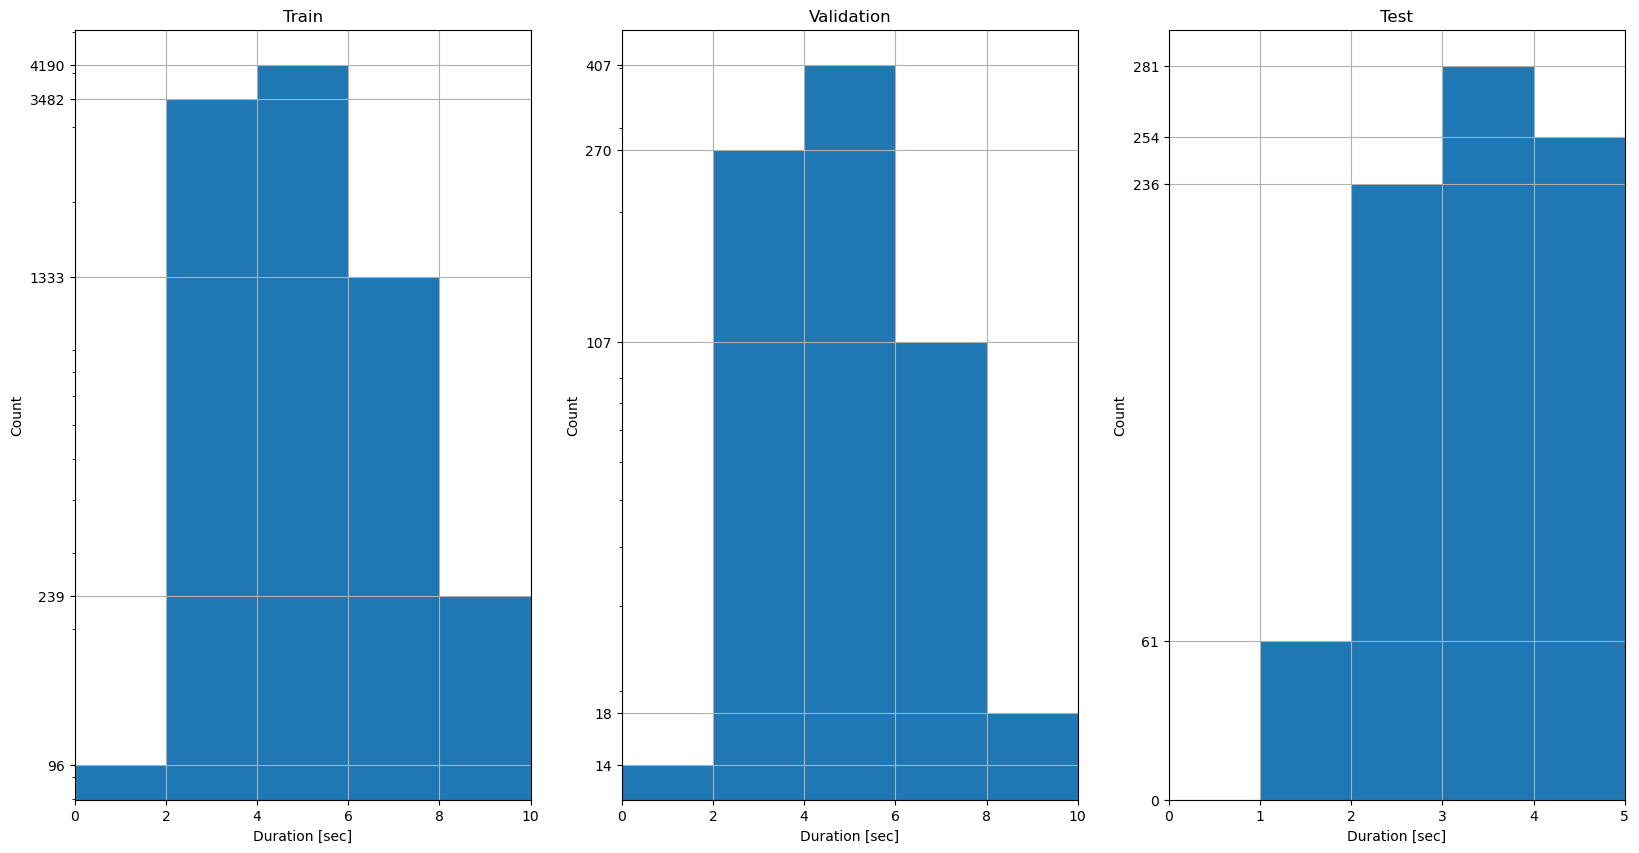

In [522]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))

counts, bins, patches = ax[0].hist(train_durations, bins=[0, 2, 4, 6, 8, 10])
ax[0].set(yscale='log', yticks=counts, yticklabels=np.array(counts, dtype=int), ylabel='Count', 
          xticks=bins, xlabel='Duration [sec]', xlim=[0, 10], title='Train')
ax[0].grid(True)

counts, bins, patches = ax[1].hist(val_durations, bins=[0, 2, 4, 6, 8, 10])
ax[1].set(yscale='log', yticks=counts, yticklabels=np.array(counts, dtype=int), ylabel='Count', 
          xticks=bins, xlabel='Duration [sec]', xlim=[0, 10], title='Validation')
ax[1].grid(True)

counts, bins, patches = ax[2].hist(test_durations, bins=[0, 1, 2, 3, 4, 5])
ax[2].set(yticks=counts, yticklabels=np.array(counts, dtype=int), ylabel='Count', 
          xticks=bins, xlabel='Duration [sec]', xlim=[0, 5], title='Test')
ax[2].grid(True)

## Обработка исключений признаков

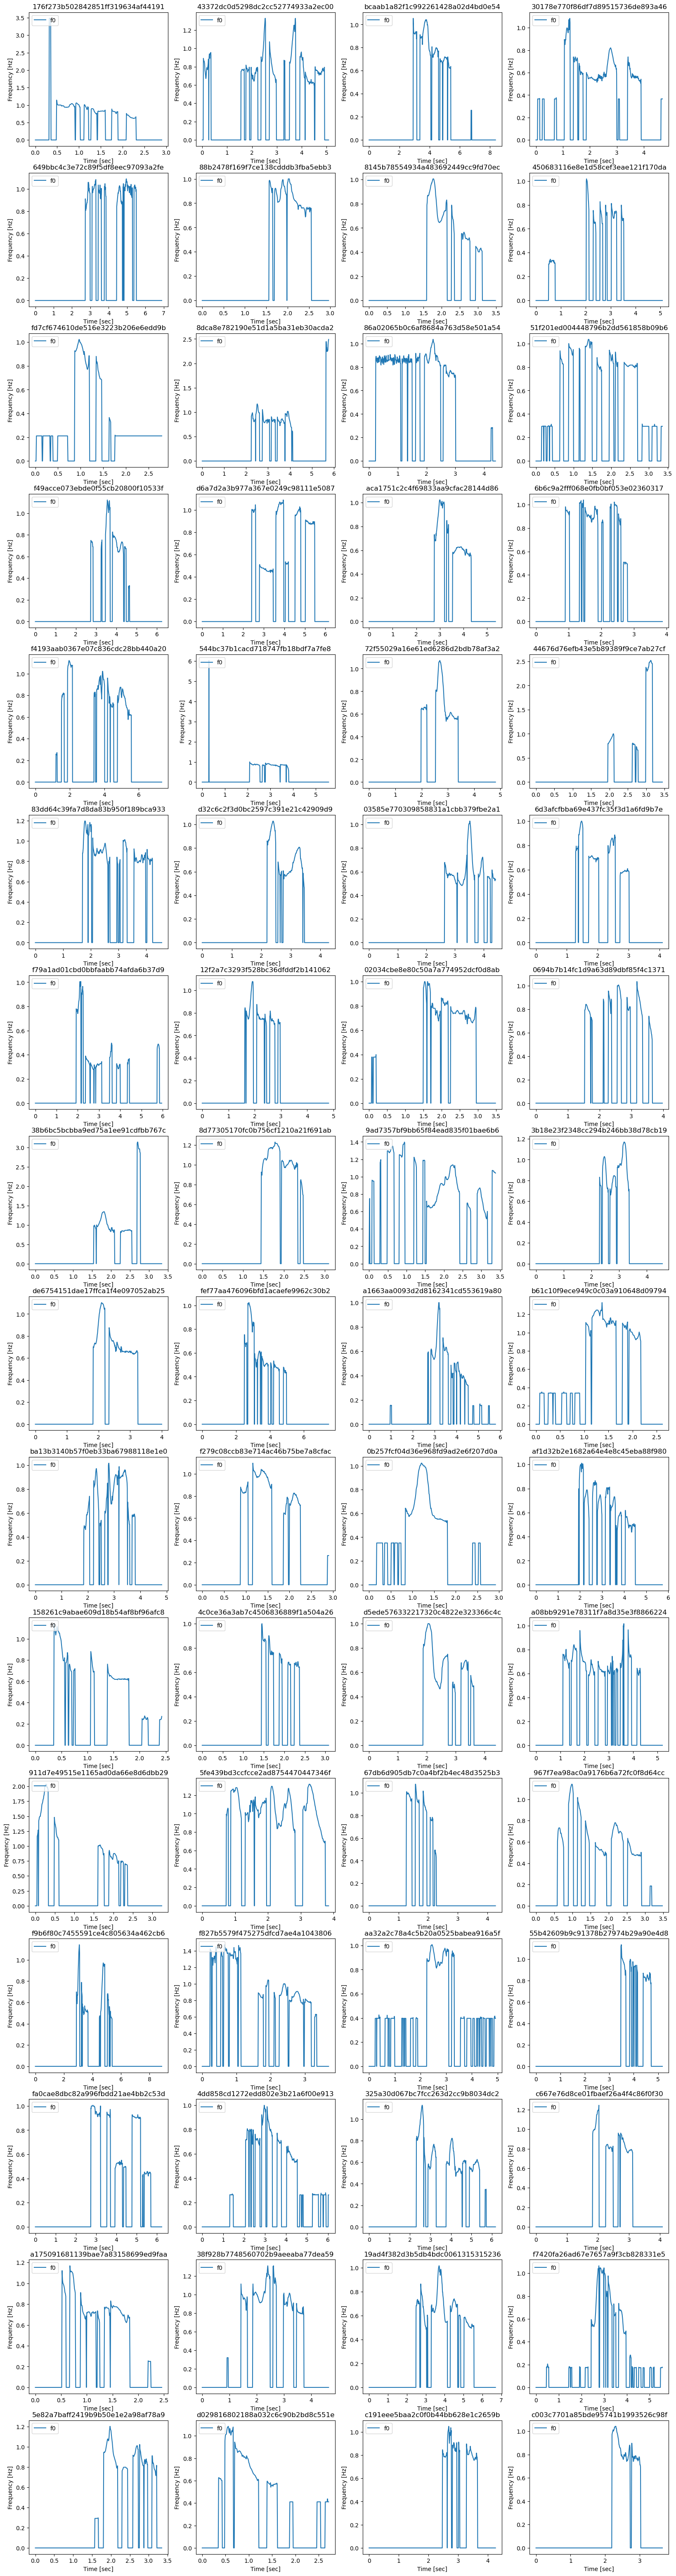

In [592]:
n = 64
random.seed(42)
audio_idxs = random.sample(range(len(final_train_df)), n)
fig, ax = plt.subplots(nrows=n // 4, ncols=4, figsize=(20, 80))
for i in range(n):
    y, sr = librosa.load('wavs/train_' + final_train_df['audio_path'][audio_idxs[i]], sr=16000)
    y = y / np.max(np.abs(y))
    f0, voicing, voicing_p = librosa.pyin(y=y, sr=sr, fmin=64., fmax=1046., frame_length=512, fill_na=0.)
    a0 = librosa.f0_harmonics(np.abs(librosa.stft(y, n_fft=512)),
                              freqs=librosa.fft_frequencies(sr=sr, n_fft=512),
                              f0=f0, harmonics=[1])
    fa = np.multiply(f0, a0)
    idx_max = np.argmax(fa)
    if len(f0[f0 > 0]) > 0:
        f0 = f0 / f0[idx_max]
    else:
        f0 = np.zeros(f0.shape)
    ax[i // 4, i % 4].set(ylabel='Frequency [Hz]', xlabel='Time [sec]', 
                          title=final_train_df['hash_id'][audio_idxs[i]])
    ax[i // 4, i % 4].plot(librosa.times_like(f0, sr=sr * 4), f0, label="f0")
    ax[i // 4, i % 4].legend(loc='upper left')

In [608]:
from transformers import SequenceFeatureExtractor, BatchFeature, TensorType
from typing import List, Optional, Union

class FeatureExtractor(SequenceFeatureExtractor):

    model_input_names = ["input_values", "attention_mask"]

    def __init__(
        self,
        feature_size=1,
        sampling_rate=16000,
        n_harmonics=4,
        max_length=1024,
        padding_value=0.0,
        do_normalize=True,
        return_attention_mask=False,
        **kwargs,
    ):
        super().__init__(feature_size=feature_size, sampling_rate=sampling_rate, padding_value=padding_value, **kwargs)
        self.n_harmonics = n_harmonics
        self.max_length = max_length
        self.do_normalize = do_normalize
        self.return_attention_mask = return_attention_mask

    def _extract_f0_harmonic_features(
        self,
        waveform: np.ndarray,
        sampling_rate: int,
        max_length: int,
        n_harm: int,
    ) -> np.ndarray:
        """
        Get f0 and harmonic features using librosa. 
        The waveform should not be normalized before feature extraction.
        """
        f0, voicing, voicing_p = librosa.pyin(waveform, sr=sampling_rate, 
                                              fmin=64., fmax=1046., 
                                              frame_length=512, fill_na=0.)
        S = np.abs(librosa.stft(waveform, n_fft=512))
        freqs = librosa.fft_frequencies(sr=sampling_rate, n_fft=512)
        f0_harm = librosa.f0_harmonics(S, freqs=freqs, f0=f0, 
                                       harmonics=np.arange(1, n_harm))
        
        # normalization
        if self.do_normalize:
            f0, f0_harm = self._normalize(f0, f0_harm)

        features = np.concatenate(([f0], f0_harm), axis=0)

        difference = max_length - features.shape[1]

        # pad or truncate, depending on difference
        if difference > 0:
            features = np.pad(features, ((0, 0), (0, difference)), 
                              mode='constant', constant_values=0.)
        elif difference < 0:
            features = features[:, :max_length]

        return np.rot90(features, axes=(1, 0))

    def _normalize(self, f0: np.ndarray, f0_harm: np.ndarray) -> np.ndarray:
        
        fa = np.multiply(f0, f0_harm[0])
        fa_idx_max = np.argmax(fa)
        if f0[fa_idx_max] > 0:
            f0 = f0 / f0[fa_idx_max]
            
        pos_mask = f0_harm > 0
        if len(f0_harm[pos_mask]) > 0:
            f0_harm[pos_mask] = np.log10(f0_harm[pos_mask])
            f0_harm[pos_mask] -= np.min(f0_harm[pos_mask])
            f0_harm = f0_harm / np.max(f0_harm)
        
        return f0, f0_harm

    def __call__(
        self,
        raw_speech: Union[np.ndarray, List[float], List[np.ndarray], List[List[float]]],
        sampling_rate: Optional[int] = None,
        return_tensors: Optional[Union[str, TensorType]] = None,
        **kwargs,
    ) -> BatchFeature:
        """
        Main method to featurize and prepare for the model one or several sequence(s).
        Args:
            raw_speech (`np.ndarray`, `List[float]`, `List[np.ndarray]`, `List[List[float]]`):
                The sequence or batch of sequences to be padded. Each sequence can be a numpy array, a list of float
                values, a list of numpy arrays or a list of list of float values.
            sampling_rate (`int`, *optional*):
                The sampling rate at which the `raw_speech` input was sampled. It is strongly recommended to pass
                `sampling_rate` at the forward call to prevent silent errors.
            return_tensors (`str` or [`~utils.TensorType`], *optional*):
                If set, will return tensors instead of list of python integers. Acceptable values are:
                - `'tf'`: Return TensorFlow `tf.constant` objects.
                - `'pt'`: Return PyTorch `torch.Tensor` objects.
                - `'np'`: Return Numpy `np.ndarray` objects.
        """

        if sampling_rate is not None:
            if sampling_rate != self.sampling_rate:
                raise ValueError(
                    f"The model corresponding to this feature extractor: {self} was trained using a sampling rate of"
                    f" {self.sampling_rate}. Please make sure that the provided `raw_speech` input was sampled with"
                    f" {self.sampling_rate} and not {sampling_rate}."
                )
        else:
            logger.warning(
                "It is strongly recommended to pass the `sampling_rate` argument to this function. "
                "Failing to do so can result in silent errors that might be hard to debug."
            )

        is_batched = bool(
            isinstance(raw_speech, (list, tuple))
            and (isinstance(raw_speech[0], np.ndarray) or isinstance(raw_speech[0], (tuple, list)))
        )

        if is_batched:
            raw_speech = [np.asarray(speech, dtype=np.float32) for speech in raw_speech]
        elif not is_batched and not isinstance(raw_speech, np.ndarray):
            raw_speech = np.asarray(raw_speech, dtype=np.float32)
        elif isinstance(raw_speech, np.ndarray) and raw_speech.dtype is np.dtype(np.float64):
            raw_speech = raw_speech.astype(np.float32)

        # always return batch
        if not is_batched:
            raw_speech = [raw_speech]

        # extract fbank features and pad/truncate to max_length
        features = [self._extract_f0_harmonic_features(waveform, sampling_rate=sampling_rate, 
                                                       max_length=self.max_length,
                                                       n_harm=self.n_harmonics) for waveform in raw_speech]

        # convert into BatchFeature
        padded_inputs = BatchFeature({"input_values": features})

        # make sure list is in array format
        input_values = padded_inputs.get("input_values")
        if isinstance(input_values[0], list):
            padded_inputs["input_values"] = [np.asarray(feature, dtype=np.float32) for feature in input_values]

        if return_tensors is not None:
            padded_inputs = padded_inputs.convert_to_tensors(return_tensors)

        return padded_inputs

In [609]:
import tqdm.notebook as tqdm
def _extract_features(df, files_dir, feature_extractor, mode, features_dir=None):
    pbar = tqdm.tqdm(range(len(df['hash_id'])), total=len(df['hash_id']))
    pbar.set_description(mode + ' dataset loading')
    wrong_features = []
    for i in pbar:
        waveform, sampling_rate = librosa.load(files_dir + df['audio_path'][i], sr=16000)
        feature = feature_extractor(waveform, sampling_rate).input_values[0]
        if np.max(feature[:, -1]) > 0:
            np.save('{0}{1}/{2}.npy'.format(features_dir, mode, df['hash_id'][i]), feature)
        else:
            wrong_features.append(df['hash_id'][i])
    return wrong_features

In [611]:
feature_extractor = FeatureExtractor(max_length=1250)
train_wrong = _extract_features(balanced_train_df, 'wavs/train_', 
                                feature_extractor=feature_extractor, 
                                mode='train', features_dir='harmonic_features/')
val_wrong =_extract_features(balanced_val_df, 'wavs/val_', 
                             feature_extractor=feature_extractor, 
                             mode='val', features_dir='harmonic_features/')
test_wrong = _extract_features(balanced_test_df, 'wavs/test_', 
                               feature_extractor=feature_extractor, 
                               mode='test', features_dir='harmonic_features/')

  0%|          | 0/9340 [00:00<?, ?it/s]

  0%|          | 0/816 [00:00<?, ?it/s]

  0%|          | 0/836 [00:00<?, ?it/s]

In [612]:
train_wrong

['59c514d8a07b01c5ecfe9b8ccdf4c261',
 '97c4642ef09e0dce1388fd987c603ddd',
 '5f76408c23f6d3e6ae10c49ff7701e39',
 '0b333a9ae01ac3fbb3a318fd148b3983',
 '175619f4e6cffad19808e7434b1234f0',
 'b0d356d62e2e8a494c16b1b91ed22974',
 'dd68c8e4c72f8538a1f8b6bb171032cb',
 '2db5e42881a6bce997fc387da53f21a0',
 'c29dc9d38b715dd16cc06a369e5e49f5',
 '91a52341e47dc71f0c30c43c26a4eef3',
 '780b3bbe1d025286fc33d5d39b41a902',
 '07abd14e23d754dba9333656790b063d',
 '4349e90494a780cb10d51f7f141f29a4',
 '69d7c730ac4fb78467a31245530da079',
 '9f029acfbdeef4a5210478bcf5d2b670',
 '03976f80548e31ffc9a5c7f175376d98',
 '0556c06c1611e5625a5d60f487fadc44',
 '204ae518571828a7e9c93acc091528b7',
 'a658c117a9d5d36333d28062c1362d11']

In [613]:
val_wrong

['6f62a342b805cf82c60c828cc32f80fb']

In [614]:
test_wrong

['bd096295ba2898f75bdda58086265571',
 '537f8b52b9fff319b2d762e0fd7254c3',
 '19bd110b6fd5099cc5c0976a90a2617f']

f283e0bd1a5932768c594acdd601f2af


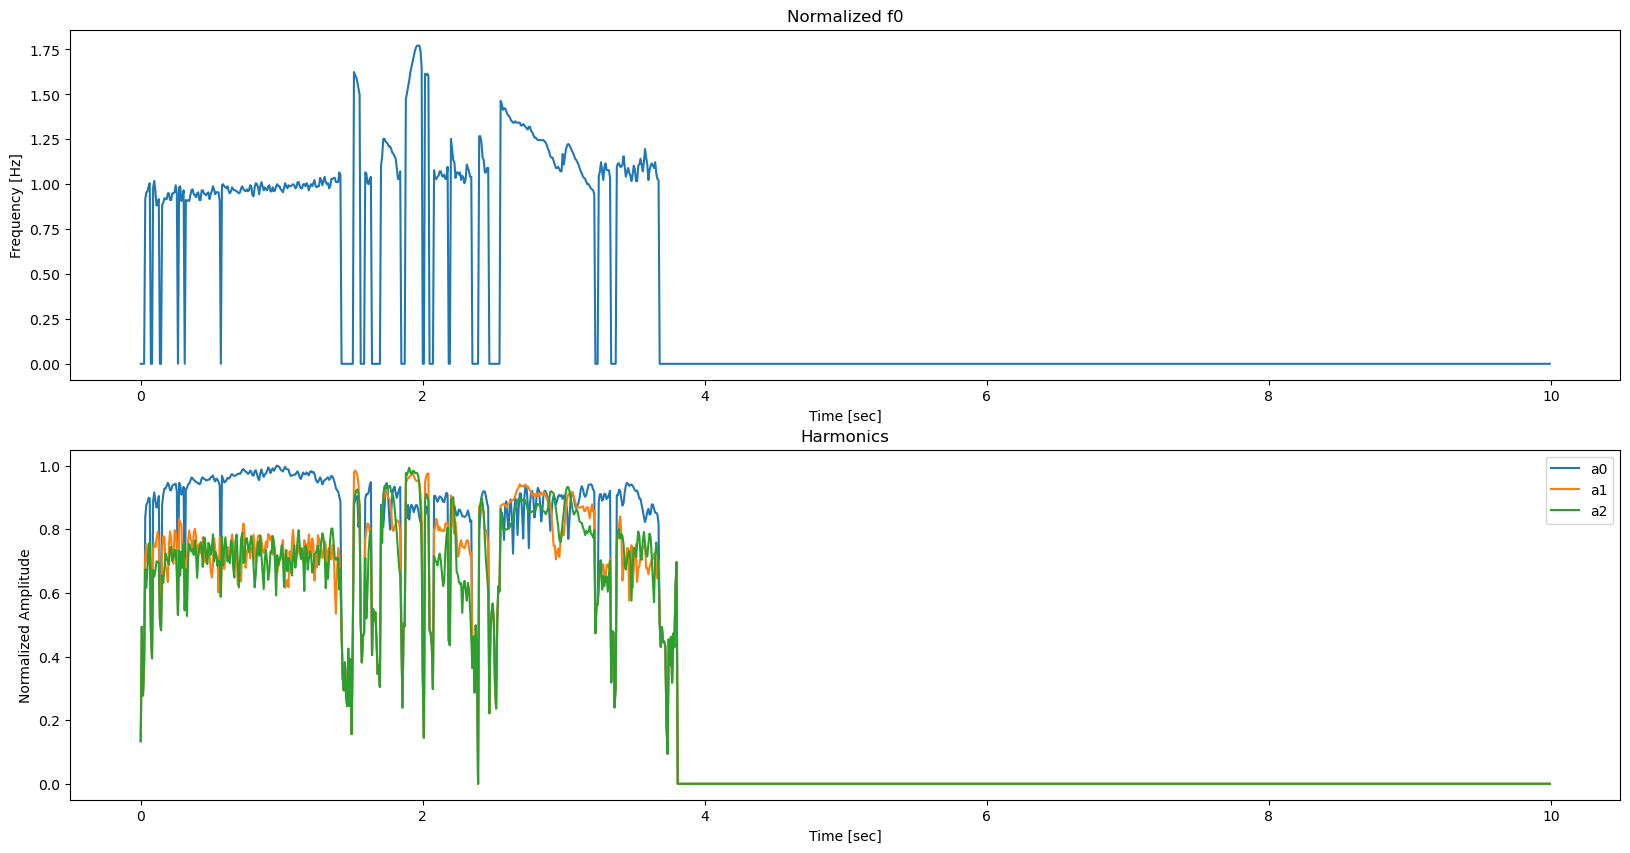

In [617]:
features_example = np.rot90(np.load('harmonic_features/train/' + balanced_train_df['hash_id'][42] + '.npy'))
print(balanced_train_df['hash_id'][42])
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
ax[0].set(ylabel='Frequency [Hz]', xlabel='Time [sec]',
          title='Normalized f0')
ax[0].plot(librosa.times_like(features_example[0], sr=16000 * 4), features_example[0])
ax[1].set(ylabel='Normalized Amplitude', xlabel='Time [sec]',
          title='Harmonics')
for i in range(1, 4):
    ax[1].plot(librosa.times_like(features_example[i], sr=16000 * 4), features_example[i], label='a{}'.format(i - 1))
ax[1].legend()

## Сохранение выборок

In [619]:
clean_final_train_df = final_train_df.drop(final_train_df[final_train_df['hash_id'].isin(train_wrong)].index)
clean_final_train_df['emotion'].value_counts()

emotion
0    2333
2    2332
3    2328
1    2328
Name: count, dtype: int64

In [620]:
clean_final_val_df = final_val_df.drop(final_val_df[final_val_df['hash_id'].isin(val_wrong)].index)
clean_final_val_df['emotion'].value_counts()

emotion
3    204
1    204
0    204
2    203
Name: count, dtype: int64

In [622]:
clean_final_test_df = final_test_df.drop(final_test_df[final_test_df['hash_id'].isin(test_wrong)].index)
clean_final_test_df['emotion'].value_counts()

emotion
3    209
0    208
2    208
1    208
Name: count, dtype: int64

In [624]:
clean_final_train_df.to_csv('train.csv', index=False)
clean_final_val_df.to_csv('val.csv', index=False)
clean_final_test_df.to_csv('test.csv', index=False)

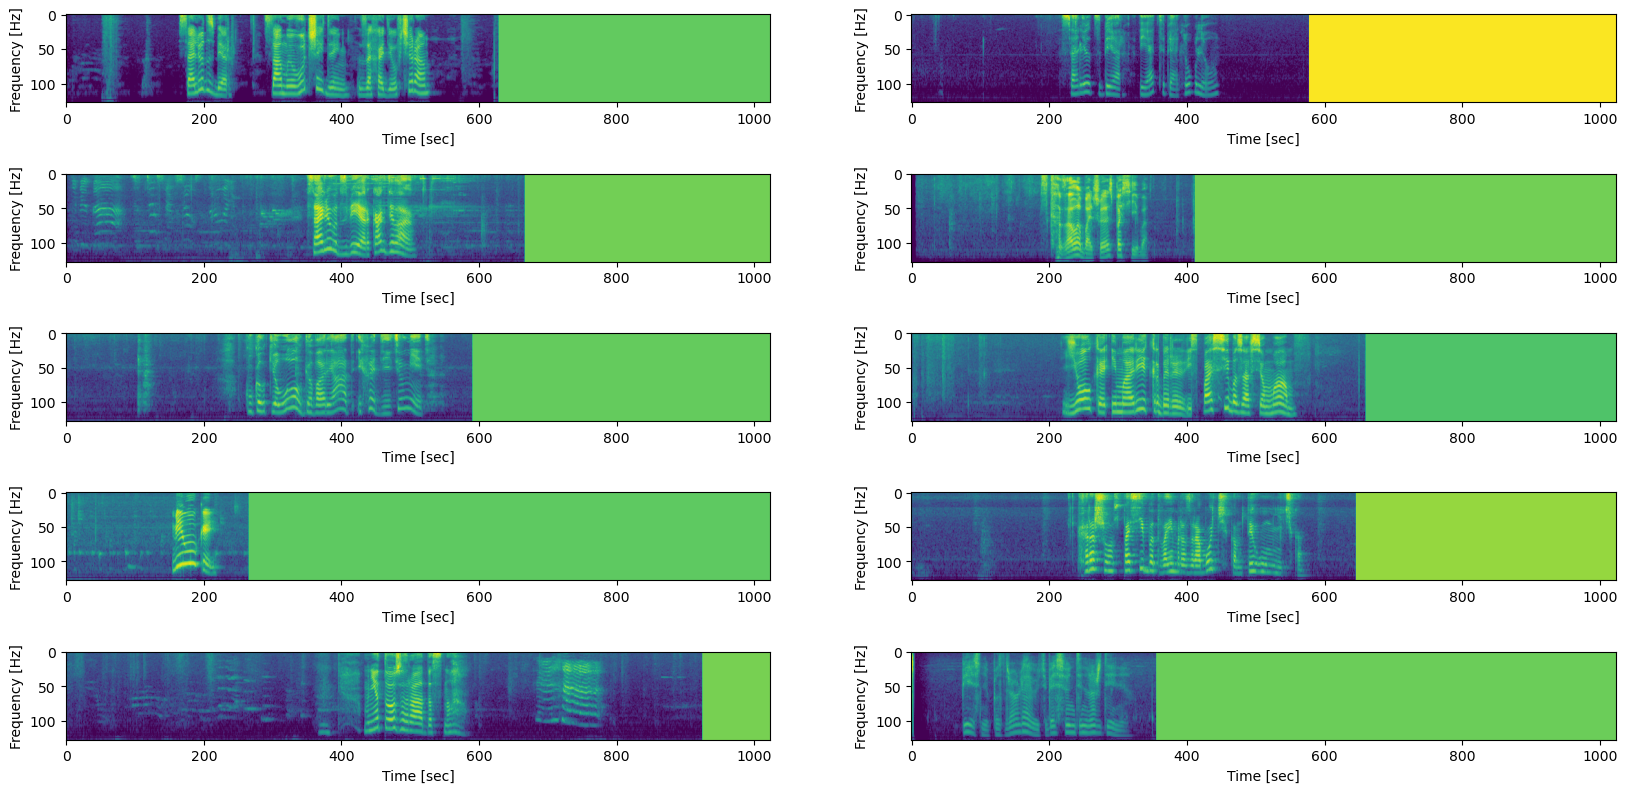

In [63]:
plt.figure(figsize=(20, 10))
pos_files = new_grouped[new_grouped['annotator_emo'] == 'positive']['audio_path'][:10].to_list()
for i in range(10):
    waveform, sampling_rate = torchaudio.load('crowd/crowd_train/' + pos_files[i])
    waveform = waveform.squeeze().numpy()
    
    inputs = feature_extractor(waveform, sampling_rate=sampling_rate, return_tensors="pt")
    input_values = inputs.input_values.numpy()
    
    plt.subplot(5, 2, i + 1)
    plt.imshow(np.rot90(input_values[0]))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    #plt.ylim([0, 1000])
    #plt.colorbar(c)
    #plt.title("Sadness")
plt.show()

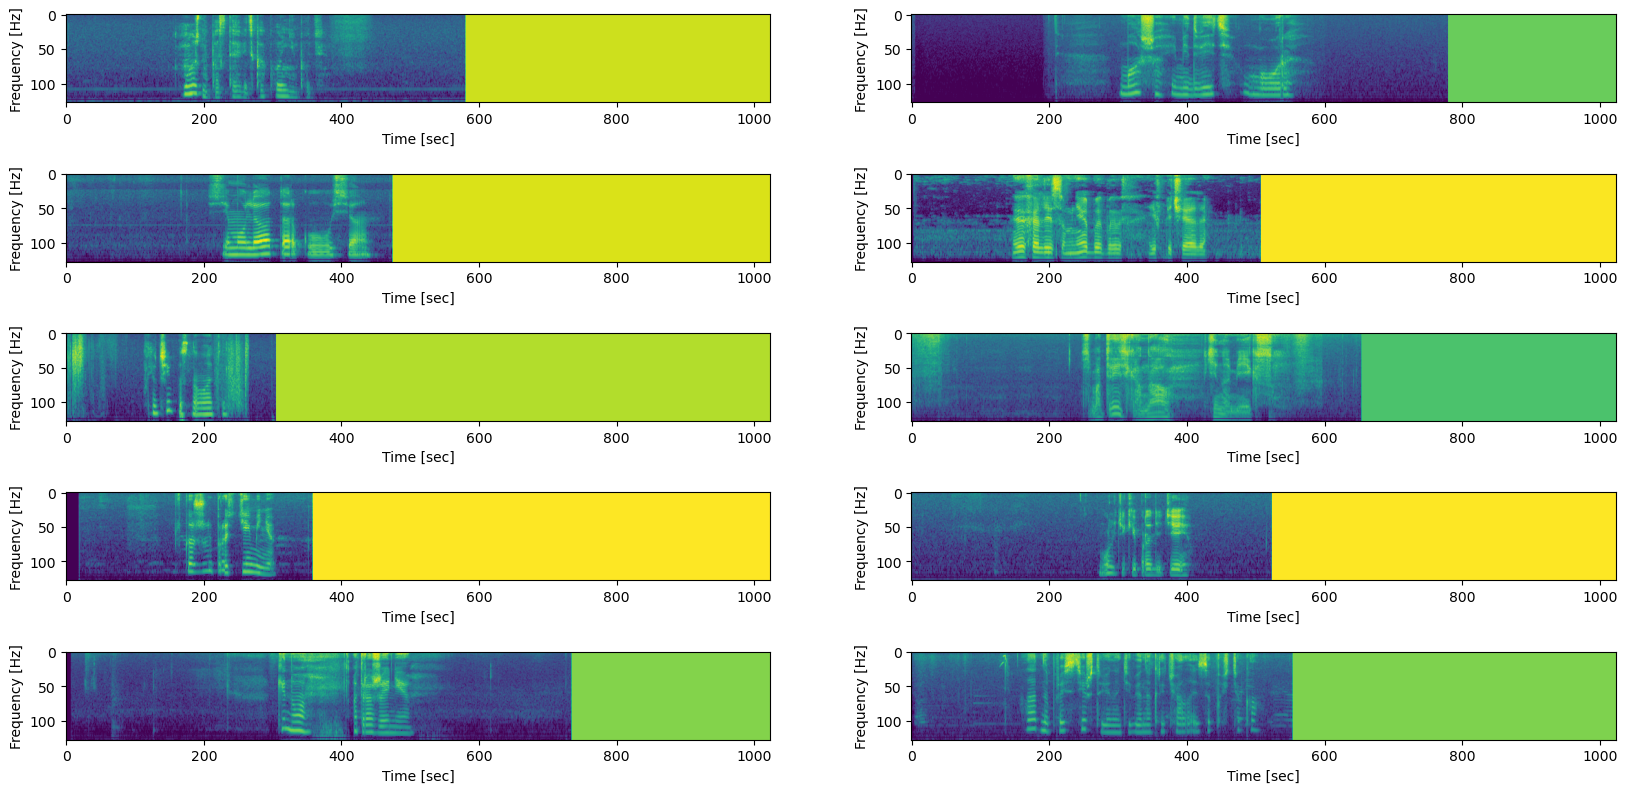

In [65]:
plt.figure(figsize=(20, 10))
sad_files = new_grouped[new_grouped['annotator_emo'] == 'sad']['audio_path'][:10].to_list()
for i in range(10):
    waveform, sampling_rate = torchaudio.load('crowd/crowd_train/' + sad_files[i])
    waveform = waveform.squeeze().numpy()
    
    inputs = feature_extractor(waveform, sampling_rate=sampling_rate, return_tensors="pt")
    input_values = inputs.input_values.numpy()
    
    plt.subplot(5, 2, i + 1)
    plt.imshow(np.rot90(input_values[0]))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    #plt.ylim([0, 1000])
    #plt.colorbar(c)
    #plt.title("Sadness")
plt.show()

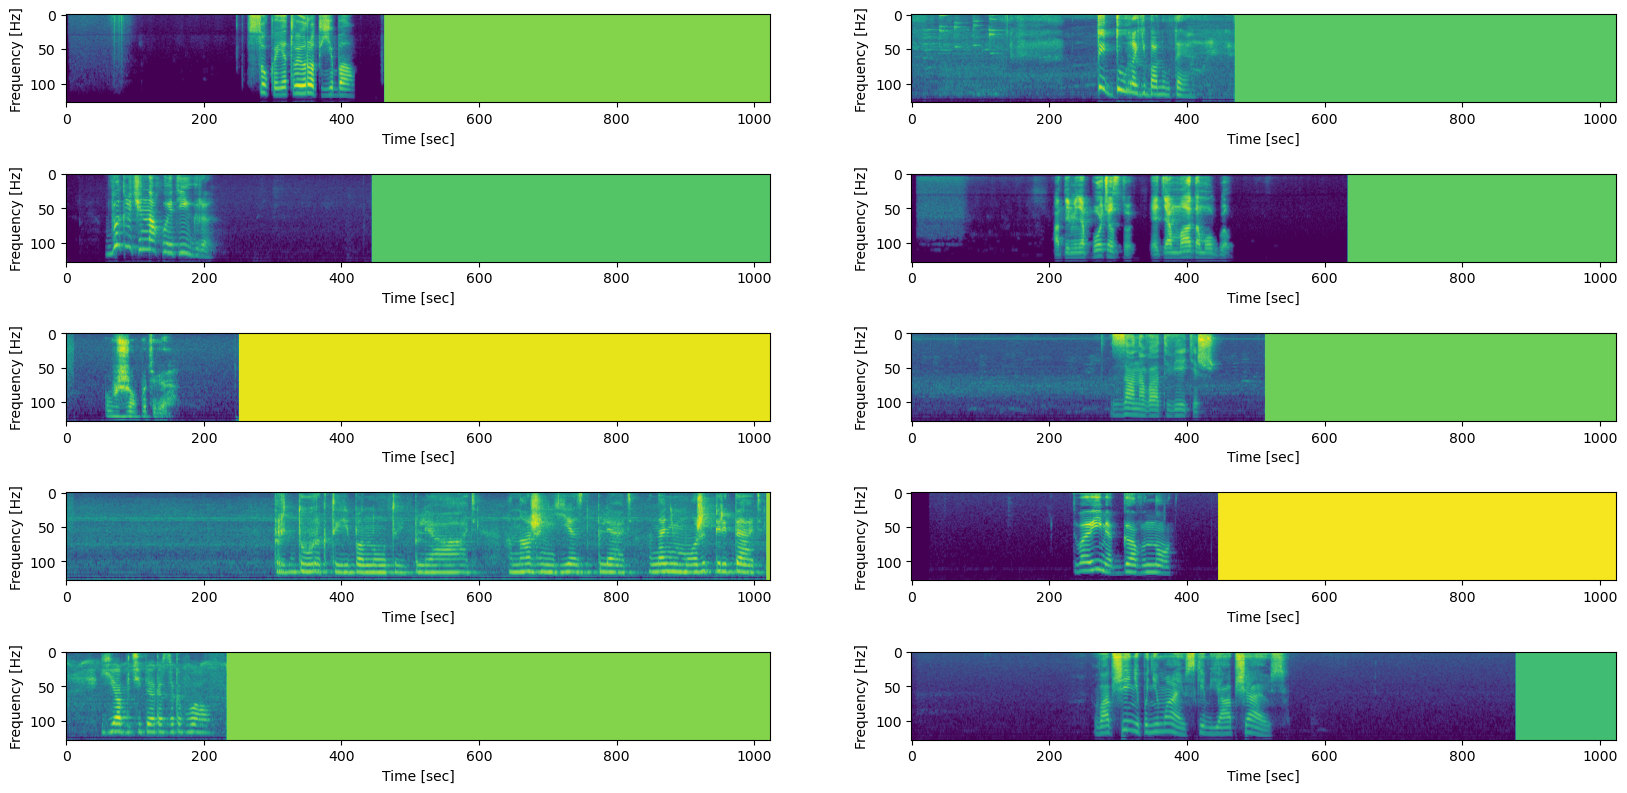

In [66]:
plt.figure(figsize=(20, 10))
ang_files = new_grouped[new_grouped['annotator_emo'] == 'angry']['audio_path'][:10].to_list()
for i in range(10):
    waveform, sampling_rate = torchaudio.load('crowd/crowd_train/' + ang_files[i])
    waveform = waveform.squeeze().numpy()
    
    inputs = feature_extractor(waveform, sampling_rate=sampling_rate, return_tensors="pt")
    input_values = inputs.input_values.numpy()
    
    plt.subplot(5, 2, i + 1)
    plt.imshow(np.rot90(input_values[0]))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    #plt.ylim([0, 1000])
    #plt.colorbar(c)
    #plt.title("Sadness")
plt.show()

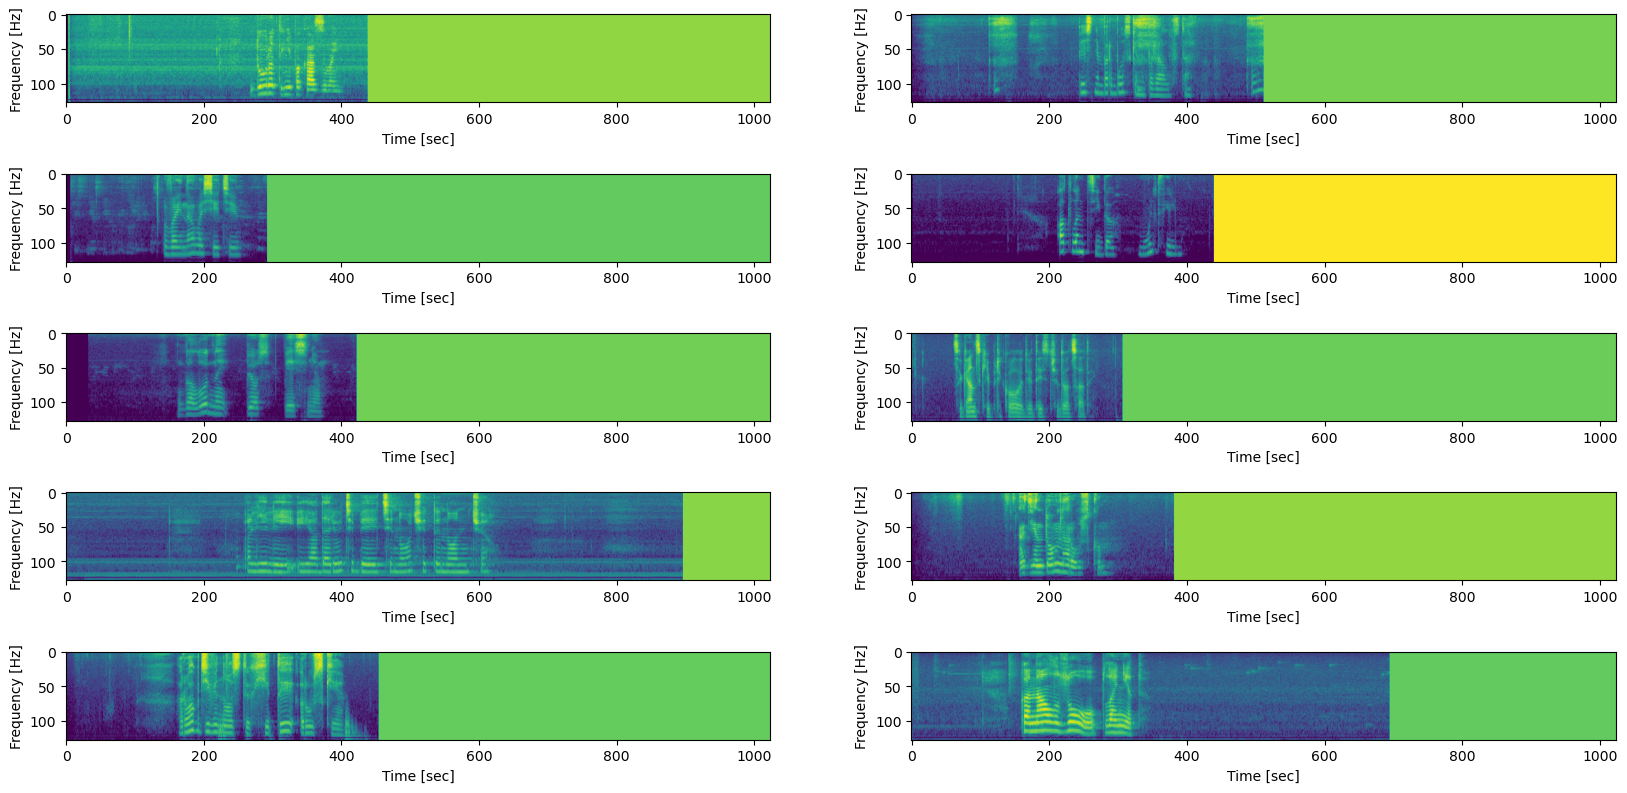

In [67]:
plt.figure(figsize=(20, 10))
neu_files = new_grouped[new_grouped['annotator_emo'] == 'neutral']['audio_path'][:10].to_list()
for i in range(10):
    waveform, sampling_rate = torchaudio.load('crowd/crowd_train/' + neu_files[i])
    waveform = waveform.squeeze().numpy()
    
    inputs = feature_extractor(waveform, sampling_rate=sampling_rate, return_tensors="pt")
    input_values = inputs.input_values.numpy()
    
    plt.subplot(5, 2, i + 1)
    plt.imshow(np.rot90(input_values[0]))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    #plt.ylim([0, 1000])
    #plt.colorbar(c)
    #plt.title("Sadness")
plt.show()

In [32]:
from transformers import ASTFeatureExtractor

feature_extractor = ASTFeatureExtractor()

In [68]:
import librosa
waveform, sampling_rate = librosa.load('happiness.wav', sr=16000)

#waveform, sampling_rate = torchaudio.load()
waveform = waveform.squeeze()#.numpy()

waveform.shape

(46936,)

In [69]:
inputs = feature_extractor(waveform, sampling_rate=sampling_rate, return_tensors="pt")
input_values = inputs.input_values.numpy()

In [70]:
print(input_values.shape)
print(input_values[0])
np.save('happiness_features.npy', input_values[0])

(1, 1024, 128)
[[-1.2775939  -1.2775939  -1.2775939  ... -1.2482897  -1.2775939
  -1.2775939 ]
 [-1.2775939  -1.2775939  -1.2775939  ... -1.2775939  -1.2775939
  -1.2775939 ]
 [-1.2775939  -1.2775939  -1.2775939  ... -1.2775939  -1.2775939
  -1.2775939 ]
 ...
 [ 0.46703237  0.46703237  0.46703237 ...  0.46703237  0.46703237
   0.46703237]
 [ 0.46703237  0.46703237  0.46703237 ...  0.46703237  0.46703237
   0.46703237]
 [ 0.46703237  0.46703237  0.46703237 ...  0.46703237  0.46703237
   0.46703237]]


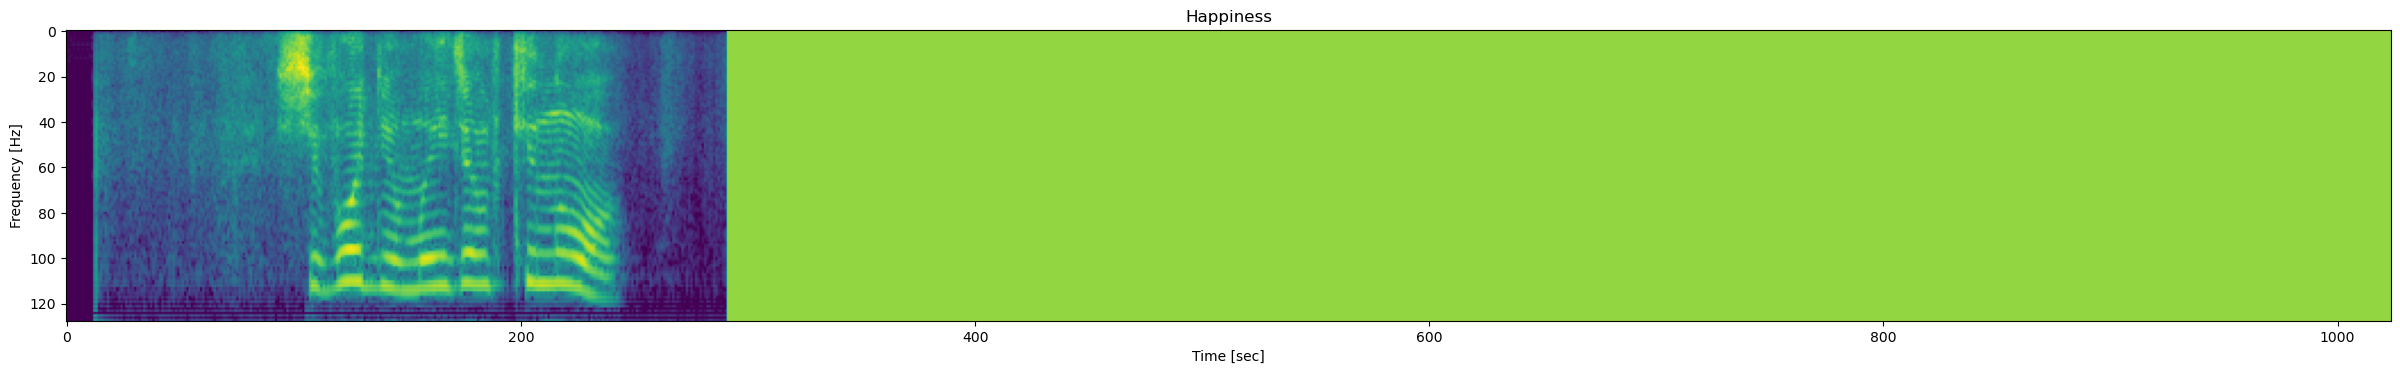

In [59]:
plt.figure(figsize=(30, 30))

plt.subplot(1, 1, 1)
#c_hap = plt.pcolormesh(input_values[0])#, vmin=0, shading='gouraud')
plt.imshow(np.rot90(input_values[0]))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
#plt.ylim([0, 1000])
#plt.colorbar(c_hap)
plt.title("Happiness")

plt.show()